# Spatial Distributions, Two-point correlation fucntions etc

Here I present plots of the spatial distribution of the Galaxies, calculate the two-point correlation functions, the radial profiles of the distributions of LSB galaxies and size-luminosity relation.

In [1]:
#Import stuff
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
#import seaborn as sns
rcParams['font.family'] = 'serif'

# Adjust rc parameters to make plots pretty
def plot_pretty(dpi=200, fontsize=8):
    
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)       # dpi resolution of saved image files
    # if you have LaTeX installed on your laptop, uncomment the line below for prettier labels
    plt.rc('text', usetex=True)      # use LaTeX to process labels
    plt.rc('font', size=1.*fontsize)    # fontsize
    plt.rc('xtick', direction='in')  # make axes ticks point inward
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=10) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=10) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1]) # fix dotted lines

    return

plot_pretty()

## Import the catalog properties now

In [2]:
from astropy.io import fits
import pandas as pd

LSBG_df = pd.read_csv('LSBG_sample.csv')


mag_g = LSBG_df['mag_g'].values
mag_r = LSBG_df['mag_r'].values
mag_i = LSBG_df['mag_i'].values

R_eff_g = LSBG_df['R_eff_g'].values
R_eff_i = LSBG_df['R_eff_i'].values
n_ser = LSBG_df['n_ser'].values

RA = LSBG_df['RA'].values
DEC = LSBG_df['DEC'].values

#LSBG_df.head()



In [3]:
# Define the colors here
col_g_i = mag_g - mag_i
col_g_r = mag_g - mag_r
col_i_r = mag_i - mag_r


# Define the point in g-i color, that divides red from blue galaxies
med_g_i = 0.59109109

## Part I: Spatial Distribution Plots

In [5]:
import skymap as smap
from skymap import DESSkymap

In [6]:
ra_red = RA[col_g_i>med_g_i]
dec_red = DEC[col_g_i>med_g_i]
# ===================================================
ra_blue = RA[(col_g_i<med_g_i)]
dec_blue = DEC[(col_g_i<med_g_i)]

In [11]:
plt.figure(figsize = (8.0,5.0))

smap = DESSkymap()

#smap.scatter(ra, dec, c='r', s=0.05,latlon=True, label="LSBGs")
#smap.scatter(ra_red, dec_red, c='r',rasterized=True, s=0.05,latlon=True)
smap.scatter(ra_blue, dec_blue, c='mediumblue', rasterized=True, s=0.05, latlon=True)
smap.draw_des(color='k',linewidth=0.7,label='DES footprint')

#smap.scatter(0,20,c='red',s=10,alpha=1, label='Red LSBGs')


plt.xlabel("RA [deg]", fontsize=20)
plt.ylabel("Dec [deg]", fontsize=20)


#smap.scatter(55.049417, -18.580111, s=10, c='y')

plt.legend(frameon=True, loc='upper left', fontsize=12)
plt.tight_layout()
#plt.savefig('Footprint.pdf',dpi=300,bbox_inches='tight',pad_inches=0)
#plt.savefig('Reds.pdf',dpi=300,bbox_inches='tight',pad_inches=0)
plt.savefig('Blues.pdf',dpi=300,bbox_inches='tight',pad_inches=0)
plt.show()

NameError: name 'DESSkymap' is not defined

<Figure size 576x360 with 0 Axes>

Now make a scatter plot of the galaxies, color coded based on their color....

In [9]:
#import matplotlib.colors as colors
#plt.figure(figsize = (8.0,5.0))
#smap = DESSkymap()

#smap.scatter(RA[(col_g_i>0.8*med_g_i)&(col_g_i<1.*med_g_i)],DEC[(col_g_i>0.8*med_g_i)&(col_g_i<1.0*med_g_i)], c='r',s=0.1,latlon=True, label="LSBGs")
#smap.draw_des(color='k',linewidth=0.7,label='DES footprint')



#plt.xlabel("RA [deg]", fontsize=20)
#plt.ylabel("DEC [deg]", fontsize=20)



#plt.legend(frameon=True, loc='upper left', fontsize=10)
#plt.tight_layout()
#plt.savefig('Color_Coded.pdf',dpi=300,bbox_inches='tight',pad_inches=0)
#plt.show()

## Part II: Auto- and Cross-correlation functions

In this part we calculate the two-point correlation functions.

In each case the errors are estimated using the jackknife approach; For $N$ jackknife resamplings, the estimation of the covariance is:

\begin{equation}
C_{ij} = \frac{N-1}{N} \sum_{k=1}^N (x_i^k - \bar{x}_i)(x_j^k - \bar{x}_j)
\end{equation}

where:

\begin{equation}
\bar{x}_i = \frac{1}{N}\sum_{k=1}^N x_i^k
\end{equation}

In [8]:
# First import some things we are gonna need
import treecorr
import healpy as hp
from astropy import units as u
from astropy.coordinates import SkyCoord

#### Write a function that calculates Jackknife errors, given a data catalog and a random catalog

In [9]:
def Jackknife(ra_dat, dec_dat, ra_rand, dec_rand, N_samples):
    """
    Inputs
    ------------------------------------------
    ra_dat: the ra of the data catalog
    dec_dat: the dec of the data catalog
     
    ra_rand: the ra of the random catalog
    dec_rand: the dac of the random catalog
    
    Outputs
    ------------------------------------------
    Errors in the two-point calculation across different scales
    """
    
    # First of all create array to store the results of the evaluations of 
    # the two point correlation functions
    Xi_vect = np.zeros([N_samples,20]) 
    
    #Create array with length equal to the length of the sample and entries 0,1,...,len(sample)
    len_smpl = len(ra_dat) #length of the sample
    
    A = np.arange(len_smpl)
    #Create array where you randomly redistribute these 
    np.random.shuffle(A)
    
    #randomize the distribution of the ra, dec vectors of the data
    ra_dat_rn = ra_dat[A]
    dec_dat_rn = dec_dat[A]
    
    # Batch size
    batch = int(len_smpl/N_samples)
    
    # =====================================================================
    # =====================================================================
    
    # Let's make a catalog for the randoms
    rand = treecorr.Catalog(ra=ra_rand, dec=dec_rand, ra_units='radians', dec_units='radians')
    rr = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
    rr.process(rand)
    
    # =====================================================================
    # =====================================================================
    #Populate the Xi_vect
    for i in range(N_samples):
        # Points to keep
        init = i*batch #Initial points not to keep
        fin = (i+1)*batch #final points not to keep
        
        # Keep data where you have excluded one batch 
        ra_dat_loc = np.concatenate((ra_dat_rn[:init],ra_dat_rn[fin:]))
        dec_dat_loc = np.concatenate((dec_dat_rn[:init],dec_dat_rn[fin:]))
        
        # Create catalog using the above data 
        cat_dat_loc = treecorr.Catalog(ra=ra_dat_loc, dec=dec_dat_loc, ra_units='deg', dec_units='deg')
        dd_loc = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
        dd_loc.process(cat_dat_loc)
        
        #data - random catalog
        dr_loc = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
        dr_loc.process(cat_dat_loc, rand)
        
        # Calculate 2pt correlation function of the sample
        xi_loc, varxi_loc = dd_loc.calculateXi(rr, dr_loc)
        
        Xi_vect[i,:] = xi_loc
    
        
    # ======================================================================
    # ======================================================================
    # Define vector to store the errors
    Err_vect = np.zeros(20)
    
    for i in range(20):
        
        Xi_i = Xi_vect[:,i]
        mean_Xi_i = np.mean(Xi_i)
        diff_sq = (Xi_i - mean_Xi_i)**2.0
        sig_sq = ((N_samples - 1.0)/N_samples)*np.sum(diff_sq)

        Err_vect[i] = np.sqrt(sig_sq)
    
    return Err_vect    

#### Create a random catalog

In [10]:
# Open MAP 
# ==========================================
MAP = hp.read_map('y3a2_footprint_grizY_any.fits')
conv = np.pi/180.
ra_min = -70.0*conv
ra_max = 110.*conv
dec_min = -70.*conv
dec_max = 10.*conv
# ========================
# ========================
rand_ra = np.random.uniform(ra_min, ra_max, 10**7)
rand_sindec = np.random.uniform(np.sin(dec_min), np.sin(dec_max), 10**7)
rand_dec = np.arcsin(rand_sindec)
# ========================

NSIDE = 4096
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


In [11]:
# Get the healpix indices of the randoms
HP_ind_rand = hp.ang2pix(4096, rand_ra/conv, rand_dec/conv, lonlat=True)

In [12]:
# Keep only those with randoms for which the value of the des mask 
# ===============================================
# ===============================================
# Keep local mask
# Get a mask - 1 inside the DES mask
DES_mask = np.zeros(len(MAP))
DES_mask[MAP>0] = 1
LOCAL_mask_rand = DES_mask[HP_ind_rand]

# Keep those with LOCAL_mask = 1
rand_ra_pos = rand_ra[LOCAL_mask_rand==1]
rand_dec_pos = rand_dec[LOCAL_mask_rand==1]

# Calculate the two point correlation function of the mpz sample
# Let's make a catalog for the randoms
rand = treecorr.Catalog(ra=rand_ra_pos, dec=rand_dec_pos, ra_units='radians', dec_units='radians')
rr = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
rr.process(rand)

#### Split LSBGs according to color and make the plot

##### First for the red galaxies

In [13]:
# Create catalog of red galaxies
cat_red = treecorr.Catalog(ra=ra_red, dec=dec_red, ra_units='deg', dec_units='deg')
dd_red = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dd_red.process(cat_red)
dr_red = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dr_red.process(cat_red, rand)
# Calculate 2pt correlation function of the red sample
xi_red, varxi_red = dd_red.calculateXi(rr, dr_red)
r_red = np.exp(dd_red.meanlogr)
sig_red = np.sqrt(varxi_red)
# Calculate Jackknife errors
# Calculate red galaxies errors
Errors_red = Jackknife(ra_red, dec_red, rand_ra_pos, rand_dec_pos, 100)

##### For the blue galaxies now

In [14]:
# Create catalog of blue galaxies
cat_blue = treecorr.Catalog(ra=ra_blue, dec=dec_blue, ra_units='deg', dec_units='deg')
dd_blue = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dd_blue.process(cat_blue)
dr_blue = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dr_blue.process(cat_blue, rand)
#Calculate 2pt correlation function of the blue sample
xi_blue, varxi_blue = dd_blue.calculateXi(rr, dr_blue)
r_blue = np.exp(dd_blue.meanlogr)
sig_blue = np.sqrt(varxi_blue)
# Calculate Jackknife errors
# Calculate blue galaxies errors
Errors_blue = Jackknife(ra_blue, dec_blue, rand_ra_pos, rand_dec_pos, 100)

##### And for all galaxies

In [15]:
# Create catalog
cat_LSBG = treecorr.Catalog(ra=RA, dec=DEC, ra_units='deg', dec_units='deg')

dd_LSBG = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dd_LSBG.process(cat_LSBG)
# ===========================================================
# ===========================================================
dr_LSBG = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dr_LSBG.process(cat_LSBG, rand)
# ===========================================================
# Calculate 2pt correlation function of the total sample
xi_LSBG, varxi_LSBG = dd_LSBG.calculateXi(rr, dr_LSBG)
r_LSBG = np.exp(dd_LSBG.meanlogr)
# Calculate Jackknife errors
# Calculate LSBG errors
Errors_LSBG = Jackknife(RA, DEC, rand_ra_pos, rand_dec_pos, 100)

In [16]:
print(len(RA))

20977


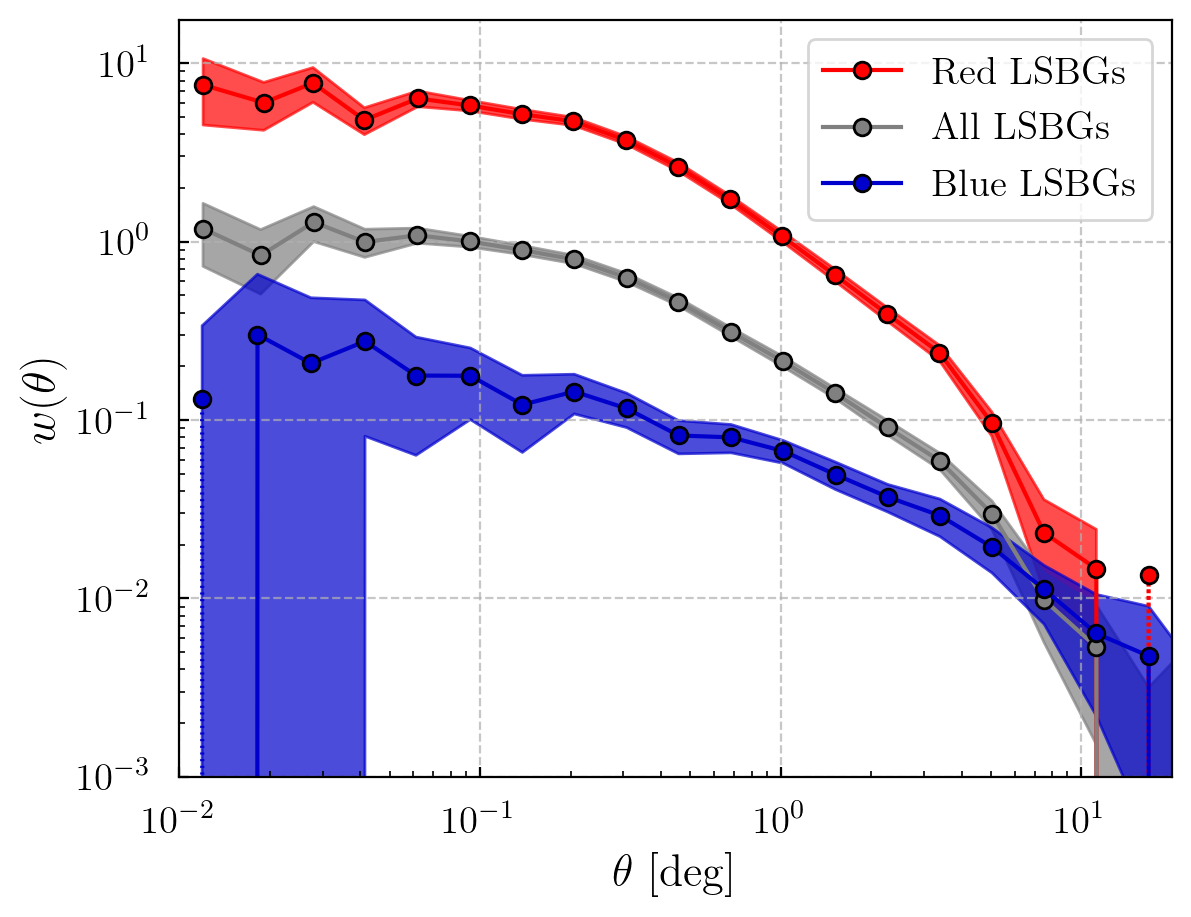

In [17]:
plt.figure(figsize = (6.,4.65))

# red galaxies
plt.plot(r_red, xi_red, color='r',marker='o', markeredgecolor='k', label='Red LSBGs')
plt.plot(r_red, -xi_red, color='r',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_red, xi_red-Errors_red, xi_red+Errors_red, color='r',
                 rasterized=True,alpha=0.7)

# All galaxies
plt.plot(r_LSBG, xi_LSBG, color='gray',marker='o', markeredgecolor='k', label='All LSBGs')
plt.plot(r_LSBG, -xi_LSBG, color='gray',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_LSBG, xi_LSBG-Errors_LSBG, xi_LSBG+Errors_LSBG, color='gray',
                 rasterized=True, alpha=0.7)


# blue galaxies
plt.plot(r_blue, xi_blue, color='mediumblue',marker='o', markeredgecolor='k', label='Blue LSBGs')
plt.plot(r_blue, -xi_blue, color='mediumblue',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_blue, xi_blue-Errors_blue, xi_blue+Errors_blue, color='mediumblue',
                 rasterized=True,alpha=0.7)


plt.grid(ls='--',alpha=0.7)
plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ [deg]', fontsize=16)



plt.ylabel(r'$w(\theta)$', fontsize=17)
plt.legend(frameon=True, loc='upper right', fontsize=14)
plt.xlim([0.01,20]);plt.ylim(1.0e-3)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.savefig('two_point_color_blue.pdf')
plt.show()

In [20]:
print(len(ra_blue)+len(ra_red))

20977


## Part III: Radial Profiles

Let's import the 2MPZ catalog now

In [21]:
from astropy.io import fits
# Open and read the 2MPZ catalog
mpz_cat = fits.open('2MPZ.fits')
#mpz_cat[1].header.keys

# Convert to rad 
rad_to_deg = 180.0/np.pi
ra_mpz = rad_to_deg*mpz_cat[1].data['RA']
dec_mpz = rad_to_deg*mpz_cat[1].data['DEC']
z_mpz = mpz_cat[1].data['ZPHOTO']

print(len(ra_mpz))
for i in range(len(ra_mpz)):
    if (ra_mpz[i] > 150.):
        ra_mpz[i] = ra_mpz[i]-360.
        
# Keep only those in the box (-70,110)&(-70,10)
box = (ra_mpz>-70.0)&(ra_mpz<110.)&(dec_mpz>-70.0)&(dec_mpz<10.0)

ra_mpz = ra_mpz[box]
dec_mpz = dec_mpz[box]
z_mpz = z_mpz[box]

# ===============================================
# ===============================================
# keep those with z<0.11

ra_mpz = ra_mpz[z_mpz<0.1]
dec_mpz = dec_mpz[z_mpz<0.10]
z_mpz = z_mpz[z_mpz<0.10]


# Get a mask - 1 inside the DES mask
DES_mask = np.zeros(len(MAP))
DES_mask[MAP>0] = 1
# ======================================================
# ======================================================
# Get the healpix indices of the mpz galaxies
HP_ind_mpz = hp.ang2pix(4096, ra_mpz, dec_mpz, lonlat=True)


# ===============================================
# Keep local mask
LOCAL_mask_mpz = DES_mask[HP_ind_mpz]

# Keep those with LOCAL_mask = 1
ra_mpz_in = ra_mpz[LOCAL_mask_mpz==1]
dec_mpz_in = dec_mpz[LOCAL_mask_mpz==1]
z_mpz_in = z_mpz[LOCAL_mask_mpz==1]

print(len(ra_mpz_in))

934175
90816


##### Define coordinates and redshifts/distances to the 9 most prominent peaks

I have decided to center everything to its best association.

In [22]:
# Right Ascension of the peaks
peaks_RA = [21.4200,55.04750,18.475833,9.888208,17.501667,54.616250,21.374583,16.929944,45.977000]

# Declination of the peaks
peaks_DEC = [-1.407222,-18.5875,-31.751944,3.138528,-45.922778,-35.448333,1.762778,-46.916526,-11.991806]

# Distance of the peaks in Mpc
peaks_dists = [75.07,23.41,84.80,62.61,106.61,18.97,73.32,102.03,57.03]

First I create radial profiles as a function of the radial distance from the center of each of the associated clusters.

In [23]:
len_sep = 16
seps = np.linspace(0.0,1.5,len_sep) # Array with separations 
dens_lsb = np.zeros([9,len_sep-1]) # Array of surface densities - LSB galaxies
dens_mpz = np.zeros([9,len_sep-1]) # Arrat of surface densities - 2MPZ galaxies


for i in range(9):
    # Coordinates of the i-th peak
    ra_pk = peaks_RA[i]
    dec_pk = peaks_DEC[i]
    # ===================================================
    # ===================================================
    # Select a box around the peak
    
    ra_up = ra_pk+3.0
    ra_low = ra_pk-3.0
    dec_up = dec_pk+3.0
    dec_low = dec_pk-3.0
    
    box_LSB = (RA>ra_low)&(RA<ra_up)&(DEC>dec_low)&(DEC<dec_up)
    box_2MPZ = (ra_mpz_in>ra_low)&(ra_mpz_in<ra_up)&(dec_mpz_in>dec_low)&(dec_mpz_in<dec_up)
    # =====================================================
    # =====================================================
    # Keep the LSB and 2MPZ galaxies inside the box
    ra_lsb_pk = RA[box_LSB]
    dec_lsb_pk = DEC[box_LSB]
    ra_mpz_pk = ra_mpz_in[box_2MPZ]
    dec_mpz_pk = dec_mpz_in[box_2MPZ]
    # =====================================================
    # =====================================================
    # Create object for the position of the peak
    C_pk = SkyCoord(ra=ra_pk*u.degree, dec=dec_pk*u.degree, frame='icrs')
    # Create object for the lsb galaxies
    C_lsb_pk = SkyCoord(ra=ra_lsb_pk*u.degree, dec=dec_lsb_pk*u.degree, frame='icrs')
    # Create object for the hsb galaxies
    C_mpz_pk = SkyCoord(ra=ra_mpz_pk*u.degree, dec=dec_mpz_pk*u.degree, frame='icrs')
    # =====================================================
    # =====================================================
    # Calculate angular separations
    sep_lsb_pk = C_lsb_pk.separation(C_pk).deg # Separation between peak and lsbs
    sep_mpz_pk = C_mpz_pk.separation(C_pk).deg # Separation between peak and 2mpz gals
    
    tot_area = np.pi*(1.5**2.0)
    mean_lsb = len(ra_lsb_pk[(sep_lsb_pk<1.5)])/tot_area # Mean number density of lsbgs
    mean_mpz = len(ra_mpz_pk[(sep_mpz_pk<1.5)])/tot_area # Mean number density of MPZs
    # =====================================================
    # =====================================================
    n_lsb = np.zeros(len_sep-1) # Array with number of LSBs
    n_mpz = np.zeros(len_sep-1) # Array with number of MPZ galaxies
    areas = np.zeros(len_sep-1) # Array with areas
    
    for j in range(len_sep-1):
        
        sep_min = seps[j] # minimum of the separation
        sep_max = seps[j+1] #maximum of the separation
        
        keep_lsb = ra_lsb_pk[(sep_lsb_pk>sep_min)&(sep_lsb_pk<=sep_max)]
        keep_mpz = ra_mpz_pk[(sep_mpz_pk>sep_min)&(sep_mpz_pk<=sep_max)]
        
        n_lsb[j] = len(keep_lsb)
        n_mpz[j] = len(keep_mpz) 
        areas[j] = np.pi*(sep_max**2.0 - sep_min**2.0)
        # ==================================================
        # ==================================================
    
    dens_lsb_loc = n_lsb/areas
    dens_mpz_loc = n_mpz/areas
    
    dens_lsb[i] = dens_lsb_loc/mean_lsb
    dens_mpz[i] = dens_mpz_loc/mean_mpz

#### Radial Profiles - Physical distance

In [24]:
len_sep = 16
seps_Mpc = np.linspace(0.0,1.5,len_sep) # Array with separations in Mpc
dens_lsb_phys = np.zeros([9,len_sep-1]) # Array of surface densities - LSB galaxies
dens_mpz_phys = np.zeros([9,len_sep-1]) # Arrat of surface densities - 2MPZ galaxies
errors_lsb = np.zeros([9,len_sep-1]) # Array to store errors in the calculation of LSBs
errors_mpz = np.zeros([9,len_sep-1]) # Array to store errors in the calculation of MPZs
# ================================================
# ================================================

for i in range(9):
    # Coordinates of the i-th peak
    ra_pk = peaks_RA[i]
    dec_pk = peaks_DEC[i]
    # ===================================================
    # ===================================================
    # Select a box around the peak
    
    ra_up = ra_pk+12.0
    ra_low = ra_pk-12.0
    dec_up = dec_pk+12.0
    dec_low = dec_pk-12.0
    
    box_LSB = (RA>ra_low)&(RA<ra_up)&(DEC>dec_low)&(DEC<dec_up)
    box_2MPZ = (ra_mpz_in>ra_low)&(ra_mpz_in<ra_up)&(dec_mpz_in>dec_low)&(dec_mpz_in<dec_up)
    # =====================================================
    # =====================================================
    # Keep the LSB and 2MPZ galaxies inside the box
    ra_lsb_pk = RA[box_LSB]
    dec_lsb_pk = DEC[box_LSB]
    ra_mpz_pk = ra_mpz_in[box_2MPZ]
    dec_mpz_pk = dec_mpz_in[box_2MPZ]
    # =====================================================
    # =====================================================
    # Create object for the position of the peak
    C_pk = SkyCoord(ra=ra_pk*u.degree, dec=dec_pk*u.degree, frame='icrs')
    # Create object for the lsb galaxies
    C_lsb_pk = SkyCoord(ra=ra_lsb_pk*u.degree, dec=dec_lsb_pk*u.degree, frame='icrs')
    # Create object for the hsb galaxies
    C_mpz_pk = SkyCoord(ra=ra_mpz_pk*u.degree, dec=dec_mpz_pk*u.degree, frame='icrs')
    # =====================================================
    # =====================================================
    # Calculate angular separations
    sep_lsb_pk = C_lsb_pk.separation(C_pk).deg # Separation between peak and lsbs
    sep_mpz_pk = C_mpz_pk.separation(C_pk).deg # Separation between peak and 2mpz gals
    
    
    # Here convert the array of physical separations to angular separations 
    seps_ang = rad_to_deg*(seps_Mpc/peaks_dists[i])
    
    max_angle = seps_ang[-1] # This is the maximum angular extend, in degrees, the corresponds to 1.5 Mpc
    tot_area = np.pi*(max_angle**2.0)
    numb_lsb = len(ra_lsb_pk[(sep_lsb_pk<max_angle)]) # Total number of LSBGs
    mean_lsb = numb_lsb/tot_area
    numb_mpz = len(ra_mpz_pk[(sep_mpz_pk<max_angle)]) # Total number of 2MPZ galaxies
    mean_mpz = numb_mpz/tot_area
    # =====================================================
    # =====================================================
    n_lsb = np.zeros(len_sep-1) # Array with number of LSBs
    n_mpz = np.zeros(len_sep-1) # Array with number of MPZ galaxies
    areas = np.zeros(len_sep-1) # Array with areas
    err_loc_lsb = np.zeros(len_sep-1)
    err_loc_mpz = np.zeros(len_sep-1)
    
    for j in range(len_sep-1):
        
        sep_min = seps_ang[j] # minimum of the separation - angle
        sep_max = seps_ang[j+1] #maximum of the separation - angle
        
        keep_lsb = ra_lsb_pk[(sep_lsb_pk>sep_min)&(sep_lsb_pk<=sep_max)]
        keep_mpz = ra_mpz_pk[(sep_mpz_pk>sep_min)&(sep_mpz_pk<=sep_max)]
        
        n_lsb[j] = len(keep_lsb)
        n_mpz[j] = len(keep_mpz) 
        areas[j] = np.pi*(sep_max**2.0 - sep_min**2.0)
        
        err_loc_lsb[j] = np.sqrt(1.0/(n_lsb[j]+1e-9) + 1.0/numb_lsb)
        err_loc_mpz[j] = np.sqrt(1.0/(n_mpz[j]+1e-9) + 1.0/numb_mpz)
        # ==================================================
        # ==================================================
    
    dens_lsb_loc = n_lsb/areas
    dens_mpz_loc = n_mpz/areas
    
    dens_lsb_phys[i] = dens_lsb_loc/mean_lsb
    dens_mpz_phys[i] = dens_mpz_loc/mean_mpz
    
    errors_lsb[i] = dens_lsb_phys[i]*err_loc_lsb
    errors_mpz[i] = dens_mpz_phys[i]*err_loc_mpz
    

#### Let's make a nice plot now!!

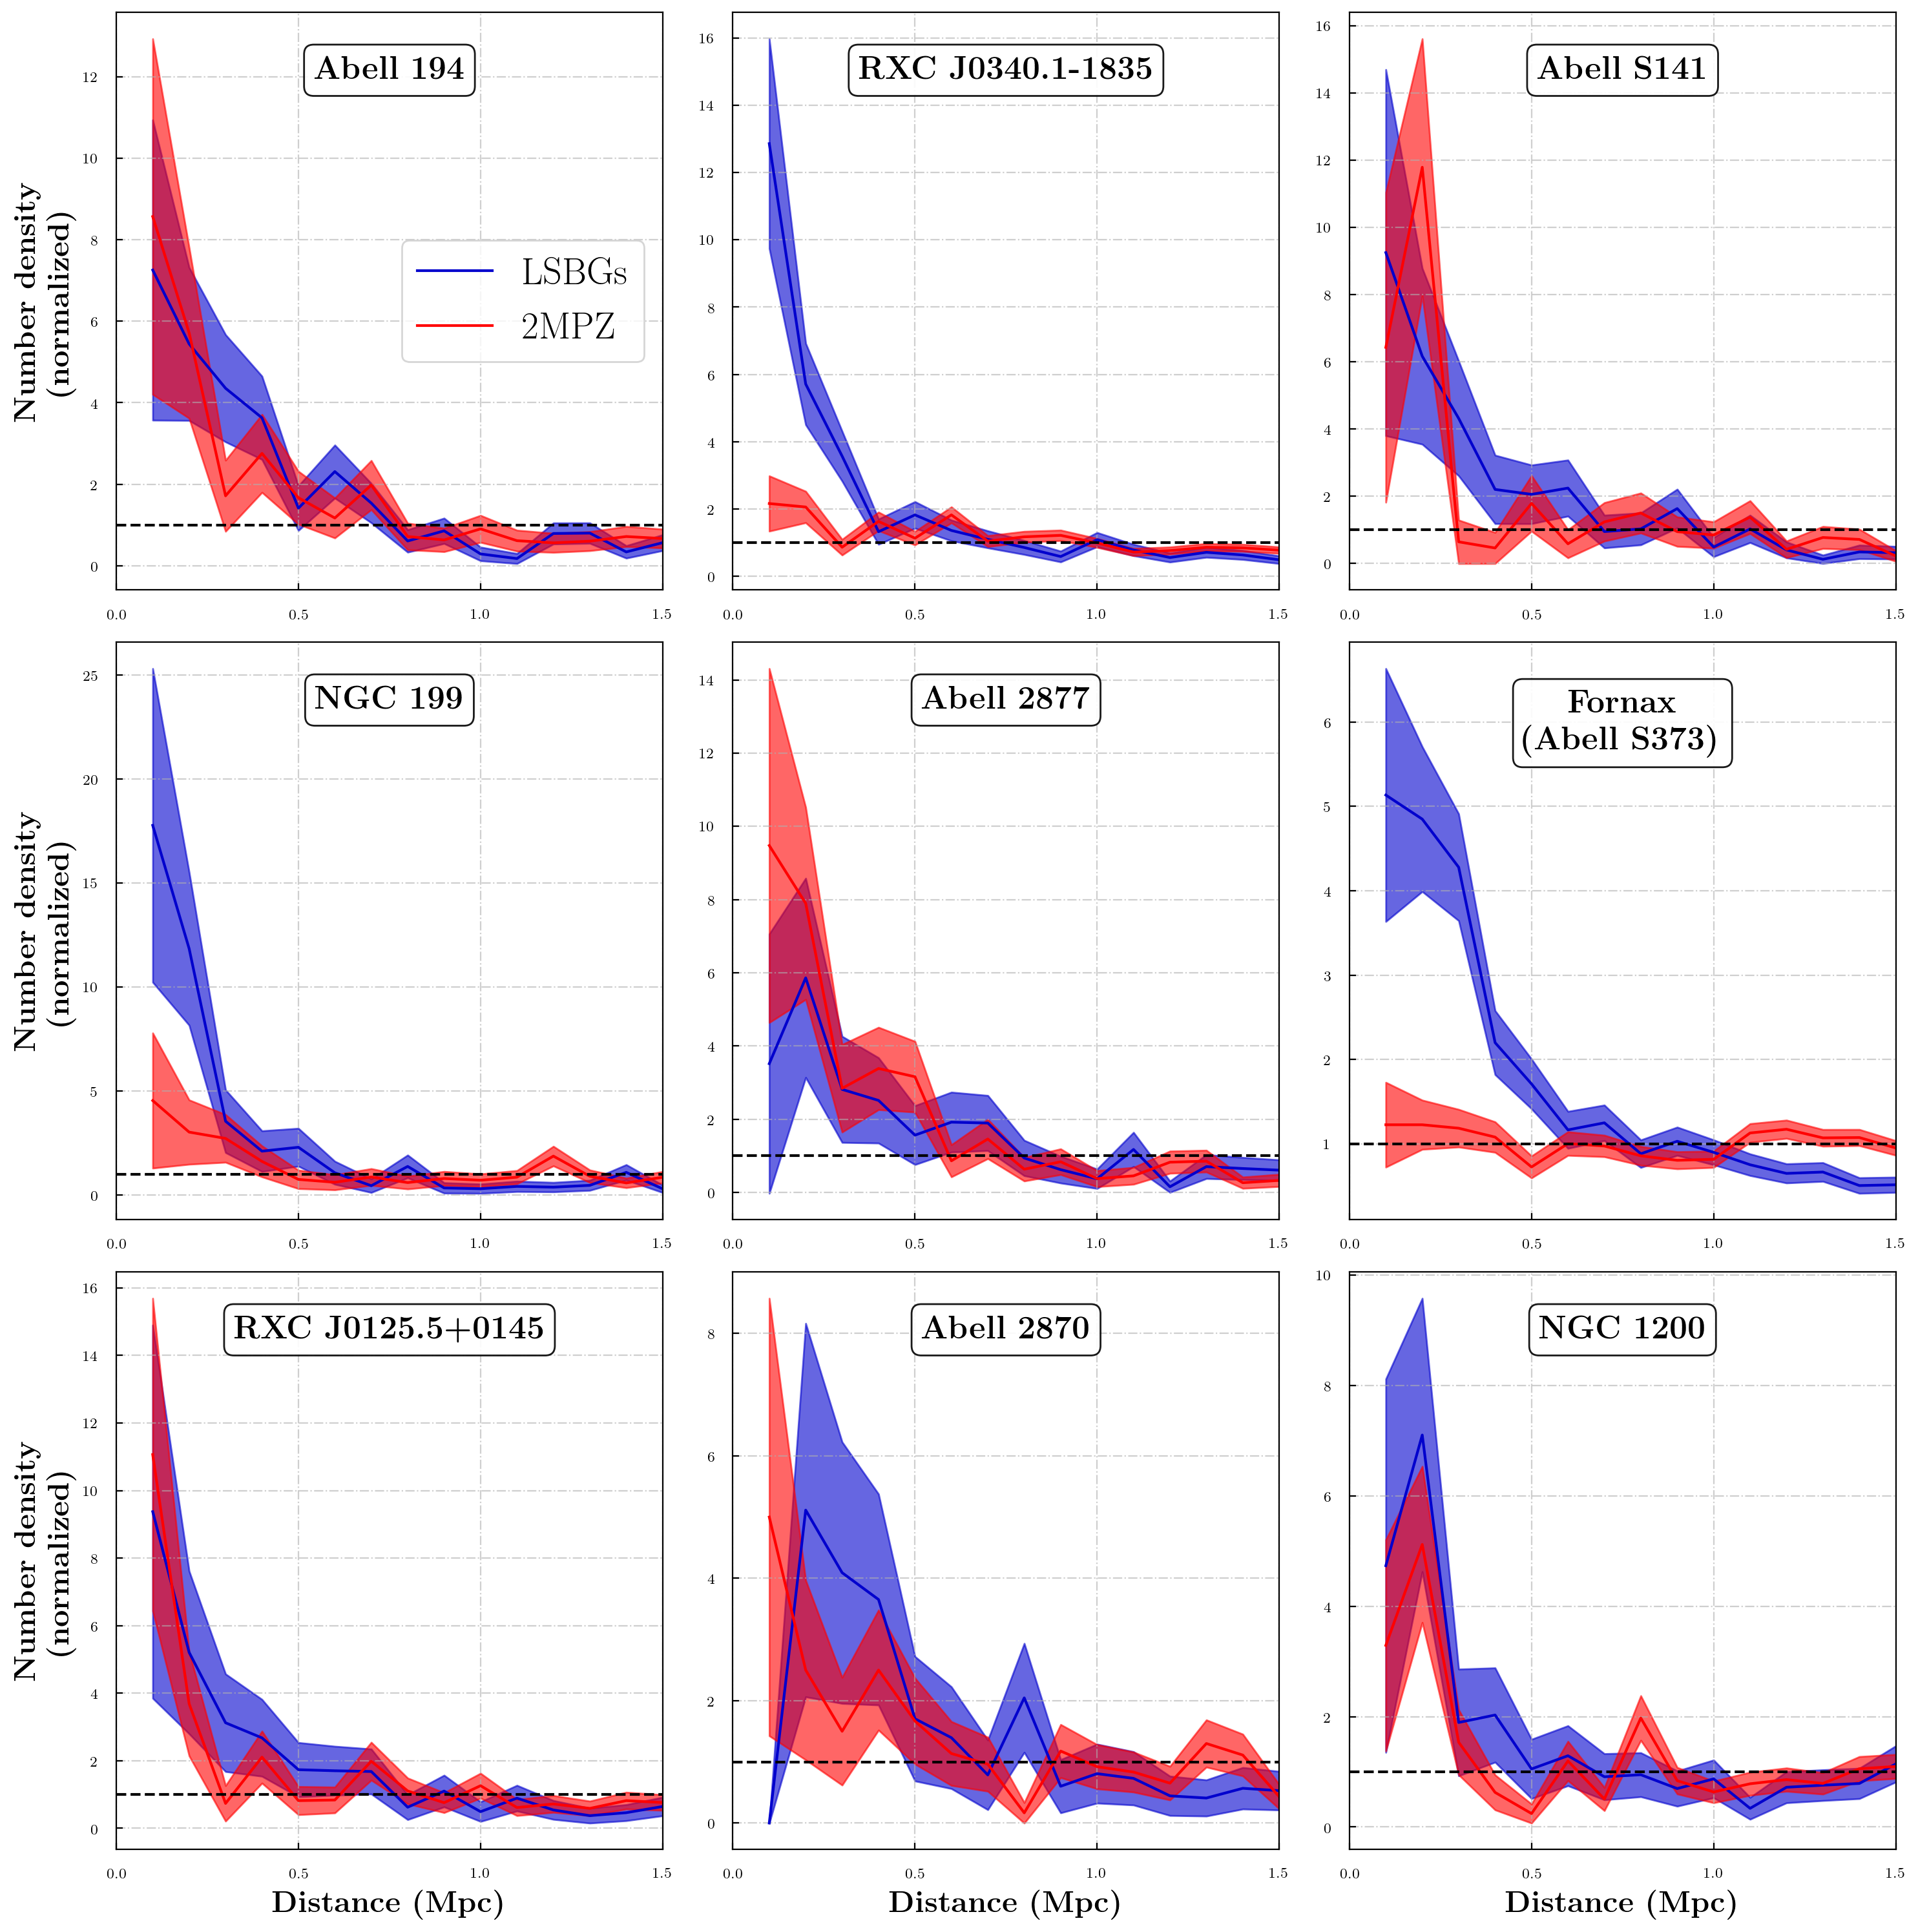

In [25]:
r = seps_Mpc[1:]
x_s = np.linspace(0.0,1.5,150)
y = np.ones(150)
Mpc_max = 1.5

props = dict(boxstyle='round', facecolor='white', alpha=0.9)


# =====================================================
# =====================================================
plot_pretty()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (15.0,15.0))

plt.rc('xtick',labelsize=17)
plt.rc('ytick',labelsize=17)


# ==========================================================
# ==========================================================
# Plots
axes[0,0].plot(r,dens_lsb_phys[0],color='mediumblue', label='LSBGs')
axes[0,0].plot(r,dens_mpz_phys[0],color='r',label='2MPZ')
# Errors
axes[0,0].fill_between(r, dens_lsb_phys[0]-errors_lsb[0],dens_lsb_phys[0]+errors_lsb[0], color='mediumblue', alpha=0.6)
axes[0,0].fill_between(r, dens_mpz_phys[0]-errors_mpz[0],dens_mpz_phys[0]+errors_mpz[0], color='r', alpha=0.6)




axes[0,0].plot(x_s,y,color='k',ls='--')
axes[0,0].grid(ls='-.',alpha=0.6)

# Customize
axes[0,0].set_xlim(0.0,Mpc_max)

axes[0,0].legend(frameon=True, loc='center right', fontsize=21, columnspacing=0.1)
axes[0,0].text(0.5 ,0.9,r'\textbf{Abell 194}', horizontalalignment='center',
               verticalalignment='center', transform=axes[0,0].transAxes,bbox=props,fontsize=18)
axes[0,0].set_ylabel(r'\textbf{Number density}''\n' r'\textbf{(normalized)}',fontsize=17)
# ==========================================================
# ==========================================================
# Plots
axes[0,1].plot(r,dens_lsb_phys[1],color='mediumblue')
axes[0,1].plot(r,dens_mpz_phys[1],color='r')
# Errors
axes[0,1].fill_between(r, dens_lsb_phys[1]-errors_lsb[1],dens_lsb_phys[1]+errors_lsb[1], color='mediumblue', alpha=0.6)
axes[0,1].fill_between(r, dens_mpz_phys[1]-errors_mpz[1],dens_mpz_phys[1]+errors_mpz[1], color='r', alpha=0.6)


axes[0,1].plot(x_s,y,color='k',ls='--')
axes[0,1].grid(ls='-.',alpha=0.6)
# Customize
axes[0,1].set_xlim(0.0,Mpc_max)
axes[0,1].text(0.5 ,0.9,r'\textbf{RXC J0340.1-1835}', horizontalalignment='center',
               verticalalignment='center', transform=axes[0,1].transAxes,bbox=props,fontsize=18)

# ==========================================================
# ==========================================================
# Plots 
axes[0,2].plot(r,dens_lsb_phys[2],color='mediumblue')
axes[0,2].plot(r,dens_mpz_phys[2],color='r')
# Errors
axes[0,2].fill_between(r, dens_lsb_phys[2]-errors_lsb[2],dens_lsb_phys[2]+errors_lsb[2], color='mediumblue', alpha=0.6)
axes[0,2].fill_between(r, dens_mpz_phys[2]-errors_mpz[2],dens_mpz_phys[2]+errors_mpz[2], color='r', alpha=0.6)




axes[0,2].plot(x_s,y,color='k',ls='--')
axes[0,2].grid(ls='-.',alpha=0.6)

# Customize
axes[0,2].set_xlim(0.0,Mpc_max)
axes[0,2].text(0.5 ,0.9,r'\textbf{Abell S141}', horizontalalignment='center',
               verticalalignment='center', transform=axes[0,2].transAxes,bbox=props,fontsize=18)

# ==========================================================
# ==========================================================
# Plots
axes[1,0].plot(r,dens_lsb_phys[3],color='mediumblue')
axes[1,0].plot(r,dens_mpz_phys[3],color='r')
# Errors
axes[1,0].fill_between(r, dens_lsb_phys[3]-errors_lsb[3],dens_lsb_phys[3]+errors_lsb[3], color='mediumblue', alpha=0.6)
axes[1,0].fill_between(r, dens_mpz_phys[3]-errors_mpz[3],dens_mpz_phys[3]+errors_mpz[3], color='r', alpha=0.6)





axes[1,0].plot(x_s,y,color='k',ls='--')
axes[1,0].grid(ls='-.',alpha=0.6)


# Customize
axes[1,0].set_xlim(0.0,Mpc_max)
axes[1,0].text(0.5 ,0.9,r'\textbf{NGC 199}', horizontalalignment='center',
               verticalalignment='center', transform=axes[1,0].transAxes,bbox=props,fontsize=18)
axes[1,0].set_ylabel(r'\textbf{Number density}''\n' r'\textbf{(normalized)}', fontsize=17)
# ==========================================================
# ==========================================================
# Plots
axes[1,1].plot(r,dens_lsb_phys[4],color='mediumblue')
axes[1,1].plot(r,dens_mpz_phys[4],color='r')
# Errors
axes[1,1].fill_between(r, dens_lsb_phys[4]-errors_lsb[4],dens_lsb_phys[4]+errors_lsb[4], color='mediumblue', alpha=0.6)
axes[1,1].fill_between(r, dens_mpz_phys[4]-errors_mpz[4],dens_mpz_phys[4]+errors_mpz[4], color='r', alpha=0.6)




axes[1,1].plot(x_s,y,color='k',ls='--')
axes[1,1].grid(ls='-.',alpha=0.6)

# Customize
axes[1,1].set_xlim(0.0,Mpc_max)
axes[1,1].text(0.5 ,0.9,r'\textbf{Abell 2877}', horizontalalignment='center',
               verticalalignment='center', transform=axes[1,1].transAxes,bbox=props,fontsize=18)


# ==========================================================
# ==========================================================
# Plots
axes[1,2].plot(r,dens_lsb_phys[5],color='mediumblue')
axes[1,2].plot(r,dens_mpz_phys[5],color='r')
# Errors
axes[1,2].fill_between(r, dens_lsb_phys[5]-errors_lsb[5],dens_lsb_phys[5]+errors_lsb[5], color='mediumblue', alpha=0.6)
axes[1,2].fill_between(r, dens_mpz_phys[5]-errors_mpz[5],dens_mpz_phys[5]+errors_mpz[5], color='r', alpha=0.6)



axes[1,2].plot(x_s,y,color='k',ls='--')
axes[1,2].grid(ls='-.',alpha=0.6)

# Customize
axes[1,2].set_xlim(0.0,Mpc_max)
axes[1,2].text(0.5 ,0.86,r'\textbf{Fornax}''\n' r'\textbf{(Abell S373)}', horizontalalignment='center',
               verticalalignment='center', transform=axes[1,2].transAxes,bbox=props,fontsize=18)


# ==========================================================
# ==========================================================
# Plots
axes[2,0].plot(r,dens_lsb_phys[6],color='mediumblue')
axes[2,0].plot(r,dens_mpz_phys[6],color='r')
# Errors
axes[2,0].fill_between(r, dens_lsb_phys[6]-errors_lsb[6],dens_lsb_phys[6]+errors_lsb[6], color='mediumblue', alpha=0.6)
axes[2,0].fill_between(r, dens_mpz_phys[6]-errors_mpz[6],dens_mpz_phys[6]+errors_mpz[6], color='r', alpha=0.6)


axes[2,0].plot(x_s,y,color='k',ls='--')
axes[2,0].grid(ls='-.',alpha=0.6)

# Customize
axes[2,0].set_xlim(0.0,Mpc_max)
axes[2,0].text(0.5 ,0.9,r'\textbf{RXC J0125.5+0145}', horizontalalignment='center',
               verticalalignment='center', transform=axes[2,0].transAxes,bbox=props,fontsize=18)

axes[2,0].set_xlabel(r'\textbf{Distance (Mpc)}', fontsize = 17)
axes[2,0].set_ylabel(r'\textbf{Number density}''\n' r'\textbf{(normalized)}', fontsize=17)
# ==========================================================
# ==========================================================
# Plots
axes[2,1].plot(r,dens_lsb_phys[7],color='mediumblue')
axes[2,1].plot(r,dens_mpz_phys[7],color='r')
# Errors
axes[2,1].fill_between(r, dens_lsb_phys[7]-errors_lsb[7],dens_lsb_phys[7]+errors_lsb[7], color='mediumblue', alpha=0.6)
axes[2,1].fill_between(r, dens_mpz_phys[7]-errors_mpz[7],dens_mpz_phys[7]+errors_mpz[7], color='r', alpha=0.6)



axes[2,1].plot(x_s,y,color='k',ls='--')
axes[2,1].grid(ls='-.',alpha=0.6)

# Customize
axes[2,1].set_xlim(0.0,Mpc_max)
axes[2,1].text(0.5 ,0.9,r'\textbf{Abell 2870}', horizontalalignment='center',
               verticalalignment='center', transform=axes[2,1].transAxes,bbox=props,fontsize=18)

axes[2,1].set_xlabel(r'\textbf{Distance (Mpc)}', fontsize = 17)
# ==========================================================
# ==========================================================
# Plots
axes[2,2].plot(r,dens_lsb_phys[8],color='mediumblue')
axes[2,2].plot(r,dens_mpz_phys[8],color='r')
# Errors
axes[2,2].fill_between(r, dens_lsb_phys[8]-errors_lsb[8],dens_lsb_phys[8]+errors_lsb[8], color='mediumblue', alpha=0.6)
axes[2,2].fill_between(r, dens_mpz_phys[8]-errors_mpz[8],dens_mpz_phys[8]+errors_mpz[8], color='r', alpha=0.6)



axes[2,2].plot(x_s,y,color='k',ls='--')
axes[2,2].grid(ls='-.',alpha=0.6)
# Customize
axes[2,2].set_xlim(0.0,Mpc_max)
axes[2,2].text(0.5 ,0.9,r'\textbf{NGC 1200}', horizontalalignment='center',
               verticalalignment='center', transform=axes[2,2].transAxes,bbox=props,fontsize=18)


axes[2,2].set_xlabel(r'\textbf{Distance (Mpc)}', fontsize = 17)

plt.tight_layout()
plt.savefig('Rad_profiles.pdf')
plt.show()

### Size-Luminosity Relation

In [26]:
rad_to_deg = 180.0/np.pi

rad_i_1 = np.zeros(46)
mag_i_1 = np.zeros(46)
rad_1 = np.zeros(46)
mag_1 = np.zeros(46)
dist_1 = np.zeros(46)
# ==========================
# ==========================
rad_i_2 = np.zeros(103)
mag_i_2 = np.zeros(103)
rad_2 = np.zeros(103)
mag_2 = np.zeros(103)
dist_2 = np.zeros(103)
# ==========================
# ==========================
rad_i_3 = np.zeros(27)
mag_i_3 = np.zeros(27)
rad_3 = np.zeros(27)
mag_3 = np.zeros(27)
dist_3 = np.zeros(27)
# ==========================
# ==========================
rad_i_4 = np.zeros(36)
mag_i_4 = np.zeros(36)
rad_4 = np.zeros(36)
mag_4 = np.zeros(36)
dist_4 = np.zeros(36)
# ==========================
# ==========================
rad_i_5 = np.zeros(19)
mag_i_5 = np.zeros(19)
rad_5 = np.zeros(19)
mag_5 = np.zeros(19)
dist_5 = np.zeros(19)
# ==========================
# ==========================
rad_i_6 = np.zeros(168)
mag_i_6 = np.zeros(168)
rad_6 = np.zeros(168)
mag_6 = np.zeros(168)
dist_6 = np.zeros(168)
# ==========================
# ==========================
rad_i_7 = np.zeros(24)
mag_i_7 = np.zeros(24)
rad_7 = np.zeros(24)
mag_7 = np.zeros(24)
dist_7 = np.zeros(24)
# ==========================
# ==========================
rad_i_8 = np.zeros(15)
mag_i_8 = np.zeros(15)
rad_8 = np.zeros(15)
mag_8 = np.zeros(15)
dist_8 = np.zeros(15)
# ==========================
# ==========================
rad_i_9 = np.zeros(25)
mag_i_9 = np.zeros(25)
rad_9 = np.zeros(25)
mag_9 = np.zeros(25)
dist_9 = np.zeros(25)

for i in range(9): # In the range of the peaks
    
    ra_pk = peaks_RA[i] # RA of the i-th peak
    dec_pk = peaks_DEC[i] # DEC of the i-th peak
    dist_pk = peaks_dists[i] # Distance of the i-th peak in Mpc
    
    
    # Create a box to select LSB galaxies
    ra_up = ra_pk+4.0
    ra_low = ra_pk-4.0
    dec_up = dec_pk+4.0
    dec_low = dec_pk-4.0
    
    box_LSB = (RA>ra_low)&(RA<ra_up)&(DEC>dec_low)&(DEC<dec_up)
    # Keep the LSB galaxies inside the box
    ra_lsb_pk = RA[box_LSB] # ra
    dec_lsb_pk = DEC[box_LSB] # dec
    R_eff_g_pk = R_eff_g[box_LSB] # Effective radius
    R_eff_i_pk = R_eff_i[box_LSB] # i-band Effective radius
    mag_g_pk = mag_g[box_LSB] # magnitude in the g band
    mag_i_pk = mag_i[box_LSB] # magnitude in the i band
    # =====================================================================
    # =====================================================================
    
    # Calculate now the angular extend of 0.5Mpc at the distance of the i-th peak
    ang_05mpc = rad_to_deg*(0.5/dist_pk)
    
    # Create object for the position of the peak
    C_pk = SkyCoord(ra=ra_pk*u.degree, dec=dec_pk*u.degree, frame='icrs')
    # Create object for the lsb galaxies
    C_lsb_pk = SkyCoord(ra=ra_lsb_pk*u.degree, dec=dec_lsb_pk*u.degree, frame='icrs')
    # =====================================================
    # Calculate angular separations
    sep_lsb_pk = C_lsb_pk.separation(C_pk).deg # Separation between peak and lsbs
    
    
    # Keep Effective radii and magnitudes with a separation less than 0.5 Mpc
    R_eff_g_05mpc = R_eff_g_pk[sep_lsb_pk<ang_05mpc]
    R_eff_i_05mpc = R_eff_i_pk[sep_lsb_pk<ang_05mpc]
    mag_g_05mpc = mag_g_pk[sep_lsb_pk<ang_05mpc]
    mag_i_05mpc = mag_i_pk[sep_lsb_pk<ang_05mpc]
    dist_05mpc = sep_lsb_pk[sep_lsb_pk<ang_05mpc] 
    
    # Now estimate the physical radius (in pc) and the absolute magnitude 
    # of the LSB galaxies around the peak
    
    deg_to_rad = 0.0174533
    radius_g = R_eff_g_05mpc*dist_pk*(4.848)
    radius_i = R_eff_i_05mpc*dist_pk*(4.848)
    Abs_mag_g = mag_g_05mpc +5.0 - 5.0*np.log10(dist_pk*1.0e6)
    Abs_mag_i = mag_i_05mpc +5.0 - 5.0*np.log10(dist_pk*1.0e6)
    phys_dist = dist_05mpc*dist_pk*(1.0e6)*deg_to_rad
    
    if (i==0):
        rad_1[:] = radius_g
        mag_1[:] = Abs_mag_g
        rad_i_1[:] = radius_i
        mag_i_1[:] = Abs_mag_i
        dist_1[:] = phys_dist
    elif (i==1):
        rad_2[:] = radius_g
        mag_2[:] = Abs_mag_g
        rad_i_2[:] = radius_i
        mag_i_2[:] = Abs_mag_i
        dist_2[:] = phys_dist
    elif (i==2):
        rad_3[:] = radius_g
        mag_3[:] = Abs_mag_g
        rad_i_3[:] = radius_i
        mag_i_3[:] = Abs_mag_i
        dist_3[:] = phys_dist
    elif (i==3):
        rad_4[:] = radius_g
        mag_4[:] = Abs_mag_g
        rad_i_4[:] = radius_i
        mag_i_4[:] = Abs_mag_i
        dist_4[:] = phys_dist
    elif (i==4):
        rad_5[:] = radius_g
        mag_5[:] = Abs_mag_g
        rad_i_5[:] = radius_i
        mag_i_5[:] = Abs_mag_i
        dist_5[:] = phys_dist
    elif (i==5):
        rad_6[:] = radius_g
        mag_6[:] = Abs_mag_g
        rad_i_6[:] = radius_i
        mag_i_6[:] = Abs_mag_i
        dist_6[:] = phys_dist
    elif (i==6):
        rad_7[:] = radius_g
        mag_7[:] = Abs_mag_g
        rad_i_7[:] = radius_i
        mag_i_7[:] = Abs_mag_i
        dist_7[:] = phys_dist
    elif (i==7):
        rad_8[:] = radius_g
        mag_8[:] = Abs_mag_g
        rad_i_8[:] = radius_i
        mag_i_8[:] = Abs_mag_i
        dist_8[:] = phys_dist
    elif (i==8):
        rad_9[:] = radius_g
        mag_9[:] = Abs_mag_g
        rad_i_9[:] = radius_i
        mag_i_9[:] = Abs_mag_i
        dist_9[:] = phys_dist
    print(len(radius_g))

46
103
27
36
19
168
24
15
25


If we want a relationship between absolute magnitude, surface brightness and effective radius (in pc), this is given by: 

\begin{equation}
R_p = (4.848\times 10^{-6}) \times 10^{\frac{5+\langle \mu \rangle - M -2.5\log 2\pi}{5}}
\end{equation}

In [27]:
M_mag = np.linspace(-19,8,500)

def R_arr(mu_mn):
    
    alpha = (5.0+mu_mn-M_mag-2.5*np.log10(2.0*np.pi))/5.0
    
    R_a = (4.848*1.0e-6)*(10.0**alpha)
    return R_a

R_arr_24 = R_arr(24.)
R_arr_25 = R_arr(25.)
R_arr_26 = R_arr(26.)
R_arr_27 = R_arr(27.)
R_arr_28 = R_arr(28.)

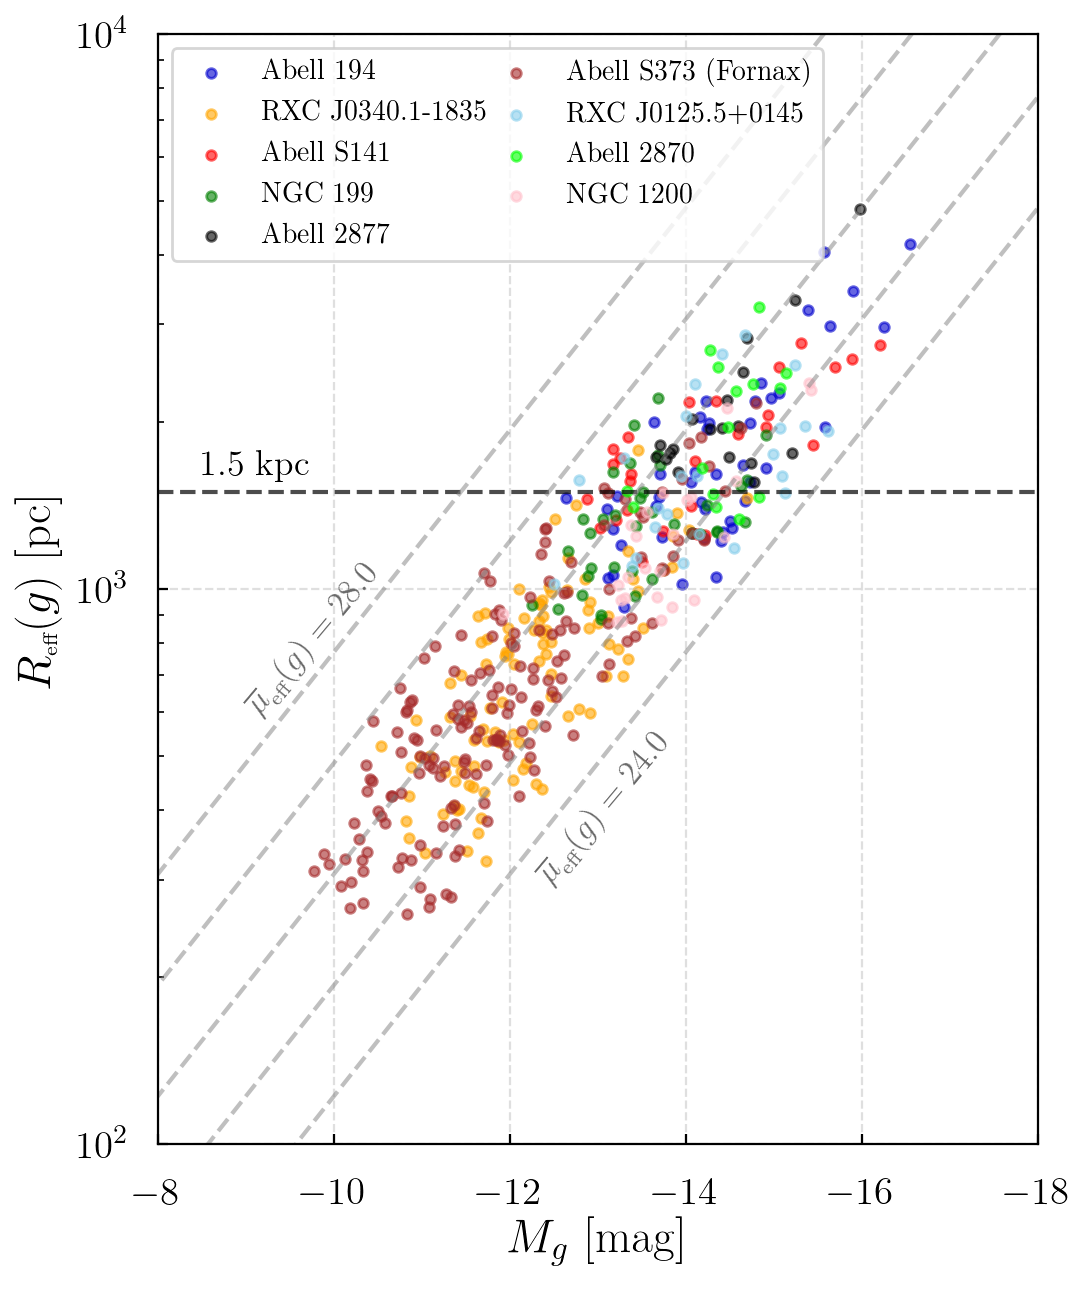

In [28]:
x_s = np.linspace(-8,-18,200)
y_s = 1839.33*np.ones(200)
y_s = 1500.0*np.ones(200)
y_s_2 = 229.91*np.ones(200)

plt.figure(figsize = (5.5,6.5))

plt.scatter(mag_1,rad_1, s=12.0, color='mediumblue', marker='o', alpha=0.6, label='Abell 194')
plt.scatter(mag_2,rad_2, s=12.0, color='orange',marker='o', alpha=0.6,label='RXC J0340.1-1835')
plt.scatter(mag_3,rad_3, s=12.0, color='red', marker='o', alpha=0.6,label='Abell S141')
plt.scatter(mag_4,rad_4, s=12.0, color='green', marker='o', alpha=0.6, label='NGC 199')
plt.scatter(mag_5,rad_5, s=12.0, color='black', marker='o', alpha=0.6,  label='Abell 2877')
plt.scatter(mag_6,rad_6, s=12.0, color='brown', marker='o', alpha=0.6,  label='Abell S373 (Fornax)')
plt.scatter(mag_7,rad_7, s=12.0, color='skyblue', marker='o', alpha=0.6, label='RXC J0125.5+0145')
plt.scatter(mag_8,rad_8, s=12.0, color='lime', marker='o', alpha=0.6, label='Abell 2870')
plt.scatter(mag_9,rad_9, s=12.0, color='pink', marker='o', alpha=0.6, label ='NGC 1200')

plt.plot(x_s,y_s, ls='--', color='k',alpha=0.7)
#plt.plot(x_s,y_s_2, ls='--', color='k',alpha=0.7)
plt.plot(M_mag, R_arr_24, ls='--',color='gray', alpha=0.5)
plt.plot(M_mag, R_arr_25, ls='--',color='gray', alpha=0.5)
plt.plot(M_mag, R_arr_26, ls='--',color='gray', alpha=0.5)
plt.plot(M_mag, R_arr_27, ls='--',color='gray', alpha=0.5)
plt.plot(M_mag, R_arr_28, ls='--',color='gray', alpha=0.5)


plt.text(-9,1.01e3, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=28.0$',color='dimgray',fontsize=12, rotation=50)
plt.text(-12.3,500, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=24.0$',color='dimgray',fontsize=12, rotation=50)
plt.text(-8.5,1.6e3, '1.5 kpc', fontsize = 13)

plt.yscale('log')
plt.ylim(1e2,1e4)
plt.xlim(-8,-18)
plt.grid(ls='--',alpha=0.4)
plt.tick_params(axis='both', labelsize=14)

plt.xlabel('$M_g$ [mag]', fontsize=17)
plt.ylabel('$R_{\mbox{\scriptsize{eff}}}(g)$ [pc]', fontsize=17)

plt.legend(frameon=True, loc='upper left', fontsize=10, ncol=2,columnspacing=0.1)

plt.tight_layout()
plt.savefig('Size_Lumin.pdf')
plt.show()

Re-create the plot having only one color

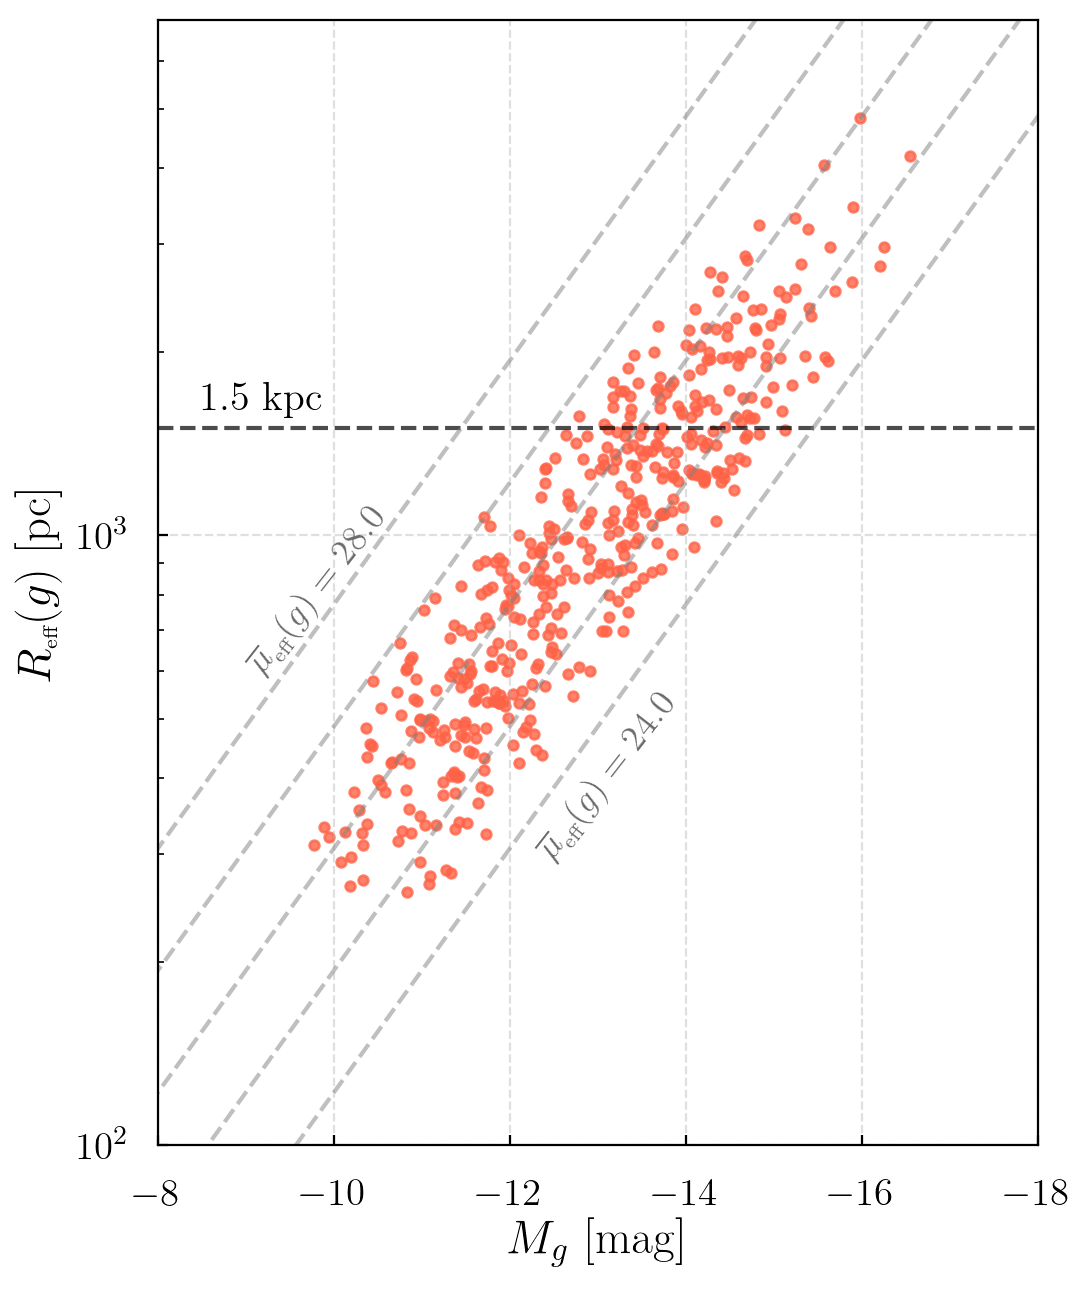

In [29]:
x_s = np.linspace(-8,-18,200)
y_s = 1839.33*np.ones(200)
y_s = 1500.0*np.ones(200)
y_s_2 = 229.91*np.ones(200)

plt.figure(figsize = (5.5,6.5))

plt.scatter(mag_1,rad_1, s=12.0, color='tomato', marker='o', alpha=0.8)
plt.scatter(mag_2,rad_2, s=12.0, color='tomato',marker='o', alpha=0.8)
plt.scatter(mag_3,rad_3, s=12.0, color='tomato', marker='o', alpha=0.8)
plt.scatter(mag_4,rad_4, s=12.0, color='tomato', marker='o', alpha=0.8)
plt.scatter(mag_5,rad_5, s=12.0, color='tomato', marker='o', alpha=0.8)
plt.scatter(mag_6,rad_6, s=12.0, color='tomato', marker='o', alpha=0.8)
plt.scatter(mag_7,rad_7, s=12.0, color='tomato', marker='o', alpha=0.8)
plt.scatter(mag_8,rad_8, s=12.0, color='tomato', marker='o', alpha=0.8)
plt.scatter(mag_9,rad_9, s=12.0, color='tomato', marker='o', alpha=0.8)

plt.plot(x_s,y_s, ls='--', color='k',alpha=0.7)
#plt.plot(x_s,y_s_2, ls='--', color='k',alpha=0.7)
plt.plot(M_mag, R_arr_24, ls='--',color='gray', alpha=0.5)
plt.plot(M_mag, R_arr_25, ls='--',color='gray', alpha=0.5)
plt.plot(M_mag, R_arr_26, ls='--',color='gray', alpha=0.5)
plt.plot(M_mag, R_arr_27, ls='--',color='gray', alpha=0.5)
plt.plot(M_mag, R_arr_28, ls='--',color='gray', alpha=0.5)


plt.text(-9,1.01e3, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=28.0$',color='dimgray',fontsize=13, rotation=52)
plt.text(-12.3,500, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=24.0$',color='dimgray',fontsize=13, rotation=52)
plt.text(-8.5,1.6e3, '1.5 kpc', fontsize = 14.5)

plt.yscale('log')
plt.ylim(1e2,7e3)
plt.xlim(-8,-18)
plt.grid(ls='--',alpha=0.4)
plt.tick_params(axis='both', labelsize=14)

plt.xlabel('$M_g$ [mag]', fontsize=17)
plt.ylabel('$R_{\mbox{\scriptsize{eff}}}(g)$ [pc]', fontsize=17)

#plt.legend(frameon=True, loc='upper left', fontsize=10, ncol=2,columnspacing=0.1)

plt.tight_layout()
plt.savefig('Size_Lumin_OC.pdf')
plt.show()

In [30]:
print(len(rad_1[rad_1>1500]))
print(len(rad_2[rad_2>1500]))
print(len(rad_3[rad_3>1500]))
print(len(rad_4[rad_4>1500]))
print(len(rad_5[rad_5>1500]))
print(len(rad_6[rad_6>1500]))
print(len(rad_7[rad_7>1500]))
print(len(rad_8[rad_8>1500]))
print(len(rad_9[rad_9>1500]))

24
1
18
9
19
9
14
10
4


In [31]:
print(len(rad_1)+len(rad_2)+len(rad_3)+len(rad_4)+len(rad_5)+len(rad_6)+len(rad_7)+len(rad_8)+len(rad_9))

463


In [32]:
print(24+1+18+9+19+9+14+10+4)
print(len(rad_1),len(rad_2),len(rad_3),len(rad_4),len(rad_5),len(rad_6),len(rad_7),len(rad_8),len(rad_9))

108
(46, 103, 27, 36, 19, 168, 24, 15, 25)


In [33]:
print(108./463.)

0.233261339093


In [34]:
print(len(ra_blue))

13829


Calculate the physical scale size at which 2''.5 correspond

In [35]:
arc_to_rad = 2.5*4.84814
lower_lims = arc_to_rad*np.asarray(peaks_dists)
x_s = np.linspace(-8,-18,200)


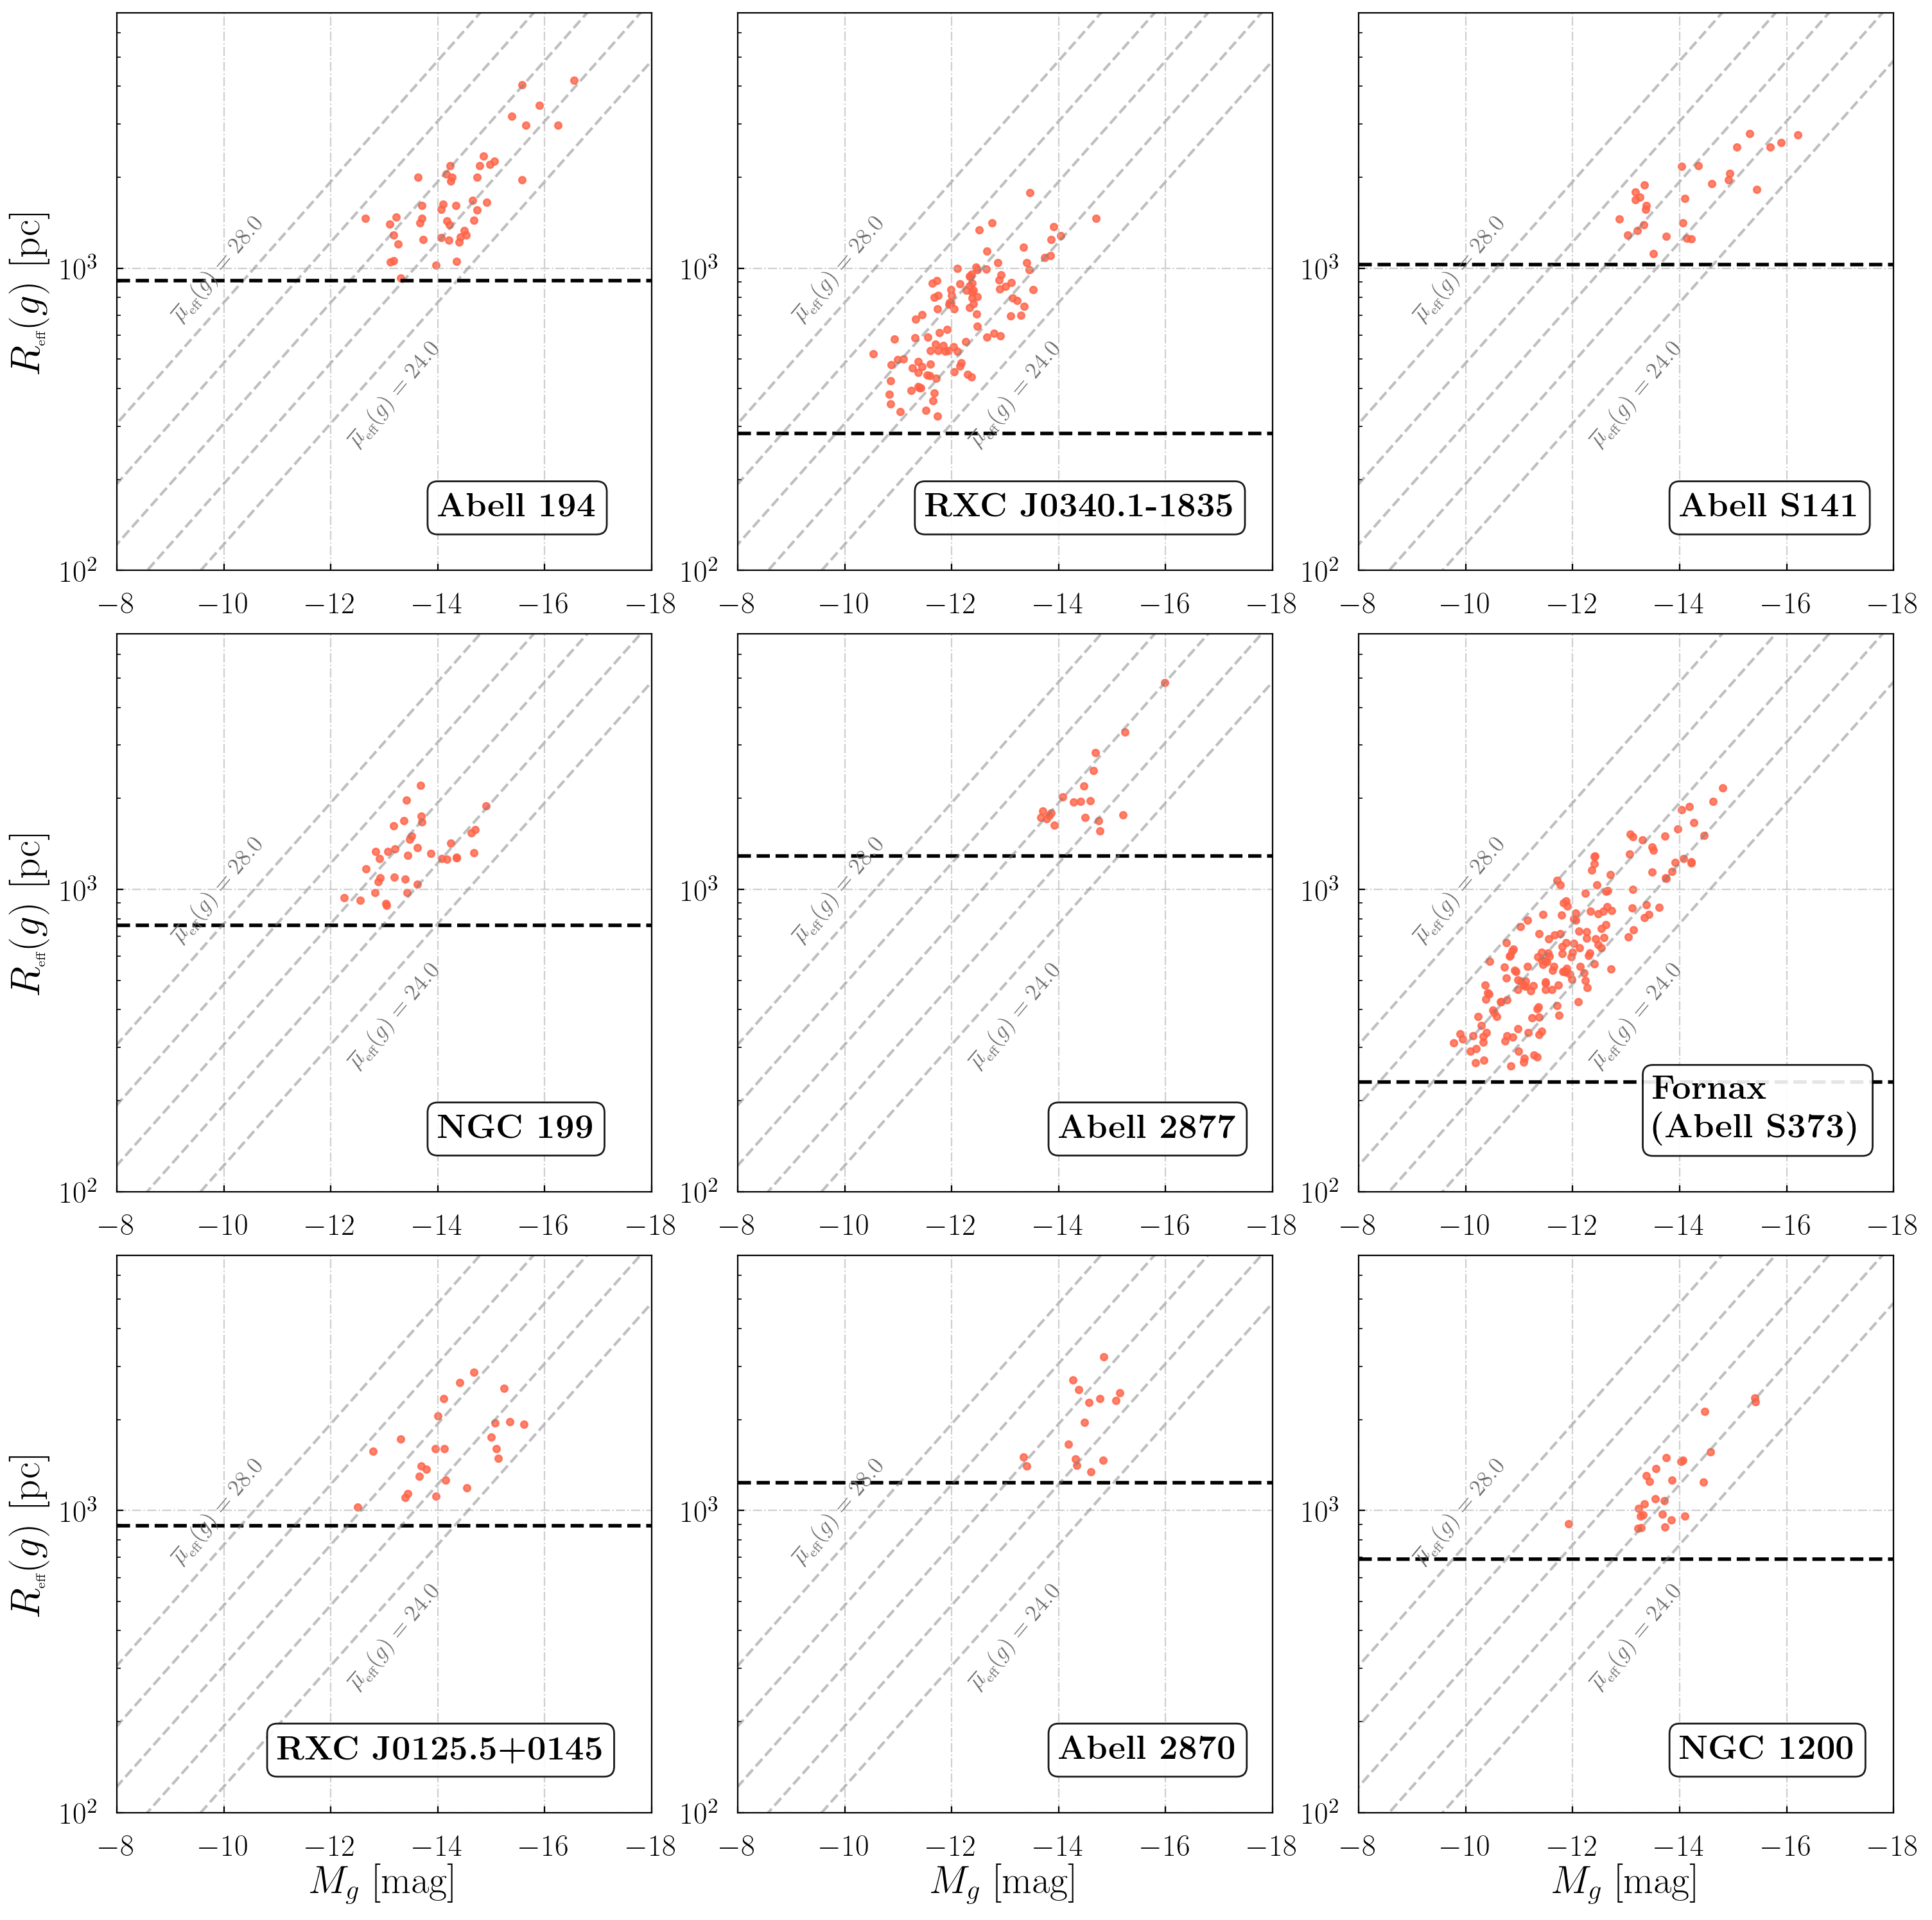

In [36]:
props = dict(boxstyle='round', facecolor='white', alpha=0.9)


# =====================================================
# =====================================================
plot_pretty()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize = (15.0,15.0))

plt.rc('xtick',labelsize=17)
plt.rc('ytick',labelsize=17)


# ==========================================================
# ==========================================================
# Plots
axes[0,0].scatter(mag_1,rad_1, s=14.0, color='tomato', marker='o', alpha=0.8)


#axes[0,0].plot(x_s,y,color='k',ls='--')
axes[0,0].grid(ls='-.',alpha=0.6)

# Customize
axes[0,0].set_yscale('log')
axes[0,0].set_ylim(1e2,7e3)
axes[0,0].set_xlim(-8,-18)

axes[0,0].plot(M_mag, R_arr_24, ls='--',color='gray', alpha=0.5)
axes[0,0].plot(M_mag, R_arr_25, ls='--',color='gray', alpha=0.5)
axes[0,0].plot(M_mag, R_arr_26, ls='--',color='gray', alpha=0.5)
axes[0,0].plot(M_mag, R_arr_27, ls='--',color='gray', alpha=0.5)
axes[0,0].plot(M_mag, R_arr_28, ls='--',color='gray', alpha=0.5)

axes[0,0].plot(x_s,lower_lims[0]*np.ones(200),ls='--',c='k',linewidth=2.0)


axes[0,0].text(-9,1.3e3, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=28.0$',color='dimgray',fontsize=13, rotation=50)
axes[0,0].text(-12.3,500, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=24.0$',color='dimgray',fontsize=13, rotation=50)
axes[0,0].text(-14,150,r'\textbf{Abell 194}',bbox=props,fontsize=19)

axes[0,0].set_ylabel(r'$R_{\mbox{\scriptsize{eff}}}(g)$ [pc]',fontsize=23)
# ==========================================================
# ==========================================================
# Plots
axes[0,1].scatter(mag_2,rad_2, s=14.0, color='tomato', marker='o', alpha=0.8)

axes[0,1].plot(x_s,lower_lims[1]*np.ones(200),ls='--',c='k',linewidth=2.0)


#axes[0,1].plot(x_s,y,color='k',ls='--')
axes[0,1].grid(ls='-.',alpha=0.6)
# Customize
axes[0,1].set_yscale('log')
axes[0,1].set_ylim(1e2,7e3)
axes[0,1].set_xlim(-8,-18)

axes[0,1].plot(M_mag, R_arr_24, ls='--',color='gray', alpha=0.5)
axes[0,1].plot(M_mag, R_arr_25, ls='--',color='gray', alpha=0.5)
axes[0,1].plot(M_mag, R_arr_26, ls='--',color='gray', alpha=0.5)
axes[0,1].plot(M_mag, R_arr_27, ls='--',color='gray', alpha=0.5)
axes[0,1].plot(M_mag, R_arr_28, ls='--',color='gray', alpha=0.5)


axes[0,1].text(-9,1.3e3, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=28.0$',color='dimgray',fontsize=13, rotation=50)
axes[0,1].text(-12.3,500, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=24.0$',color='dimgray',fontsize=13, rotation=50)
axes[0,1].text(-11.5,150,r'\textbf{RXC J0340.1-1835}',bbox=props,fontsize=19)



# ==========================================================
# ==========================================================
# Plots 
axes[0,2].scatter(mag_3,rad_3, s=14.0, color='tomato', marker='o', alpha=0.8)
axes[0,2].plot(x_s,lower_lims[2]*np.ones(200),ls='--',c='k',linewidth=2.0)



#axes[0,2].plot(x_s,y,color='k',ls='--')
axes[0,2].grid(ls='-.',alpha=0.6)

# Customize
axes[0,2].set_yscale('log')
axes[0,2].set_ylim(1e2,7e3)
axes[0,2].set_xlim(-8,-18)

axes[0,2].plot(M_mag, R_arr_24, ls='--',color='gray', alpha=0.5)
axes[0,2].plot(M_mag, R_arr_25, ls='--',color='gray', alpha=0.5)
axes[0,2].plot(M_mag, R_arr_26, ls='--',color='gray', alpha=0.5)
axes[0,2].plot(M_mag, R_arr_27, ls='--',color='gray', alpha=0.5)
axes[0,2].plot(M_mag, R_arr_28, ls='--',color='gray', alpha=0.5)


axes[0,2].text(-9,1.3e3, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=28.0$',color='dimgray',fontsize=13, rotation=50)
axes[0,2].text(-12.3,500, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=24.0$',color='dimgray',fontsize=13, rotation=50)
axes[0,2].text(-14,150,r'\textbf{Abell S141}',bbox=props,fontsize=19)


# ==========================================================
# ==========================================================
# Plots
axes[1,0].scatter(mag_4,rad_4, s=14.0, color='tomato', marker='o', alpha=0.8)

axes[1,0].plot(x_s,lower_lims[3]*np.ones(200),ls='--',c='k',linewidth=2.0)

#axes[1,0].plot(x_s,y,color='k',ls='--')
axes[1,0].grid(ls='-.',alpha=0.6)


# Customize
axes[1,0].set_yscale('log')
axes[1,0].set_ylim(1e2,7e3)
axes[1,0].set_xlim(-8,-18)


axes[1,0].plot(M_mag, R_arr_24, ls='--',color='gray', alpha=0.5)
axes[1,0].plot(M_mag, R_arr_25, ls='--',color='gray', alpha=0.5)
axes[1,0].plot(M_mag, R_arr_26, ls='--',color='gray', alpha=0.5)
axes[1,0].plot(M_mag, R_arr_27, ls='--',color='gray', alpha=0.5)
axes[1,0].plot(M_mag, R_arr_28, ls='--',color='gray', alpha=0.5)


axes[1,0].text(-9,1.3e3, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=28.0$',color='dimgray',fontsize=13, rotation=50)
axes[1,0].text(-12.3,500, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=24.0$',color='dimgray',fontsize=13, rotation=50)
axes[1,0].text(-14,150,r'\textbf{NGC 199}',bbox=props,fontsize=19)

axes[1,0].set_ylabel(r'$R_{\mbox{\scriptsize{eff}}}(g)$ [pc]', fontsize=23)
# ==========================================================
# ==========================================================
# Plots
axes[1,1].scatter(mag_5,rad_5, s=14.0, color='tomato', marker='o', alpha=0.8)
axes[1,1].plot(x_s,lower_lims[4]*np.ones(200),ls='--',c='k',linewidth=2.0)


#axes[1,1].plot(x_s,y,color='k',ls='--')
axes[1,1].grid(ls='-.',alpha=0.6)

# Customize
axes[1,1].set_yscale('log')
axes[1,1].set_ylim(1e2,7e3)
axes[1,1].set_xlim(-8,-18)

axes[1,1].plot(M_mag, R_arr_24, ls='--',color='gray', alpha=0.5)
axes[1,1].plot(M_mag, R_arr_25, ls='--',color='gray', alpha=0.5)
axes[1,1].plot(M_mag, R_arr_26, ls='--',color='gray', alpha=0.5)
axes[1,1].plot(M_mag, R_arr_27, ls='--',color='gray', alpha=0.5)
axes[1,1].plot(M_mag, R_arr_28, ls='--',color='gray', alpha=0.5)


axes[1,1].text(-9,1.3e3, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=28.0$',color='dimgray',fontsize=13, rotation=50)
axes[1,1].text(-12.3,500, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=24.0$',color='dimgray',fontsize=13, rotation=50)
axes[1,1].text(-14,150,r'\textbf{Abell 2877}',bbox=props,fontsize=19)


# ==========================================================
# ==========================================================
# Plots
axes[1,2].scatter(mag_6,rad_6, s=14.0, color='tomato', marker='o', alpha=0.8)
axes[1,2].plot(x_s,lower_lims[5]*np.ones(200),ls='--',c='k',linewidth=2.0)



#axes[1,2].plot(x_s,y,color='k',ls='--')
axes[1,2].grid(ls='-.',alpha=0.6)

# Customize
axes[1,2].set_yscale('log')
axes[1,2].set_ylim(1e2,7e3)
axes[1,2].set_xlim(-8,-18)

axes[1,2].plot(M_mag, R_arr_24, ls='--',color='gray', alpha=0.5)
axes[1,2].plot(M_mag, R_arr_25, ls='--',color='gray', alpha=0.5)
axes[1,2].plot(M_mag, R_arr_26, ls='--',color='gray', alpha=0.5)
axes[1,2].plot(M_mag, R_arr_27, ls='--',color='gray', alpha=0.5)
axes[1,2].plot(M_mag, R_arr_28, ls='--',color='gray', alpha=0.5)


axes[1,2].text(-9,1.3e3, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=28.0$',color='dimgray',fontsize=13, rotation=50)
axes[1,2].text(-12.3,500, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=24.0$',color='dimgray',fontsize=13, rotation=50)
axes[1,2].text(-13.5,150,r'\textbf{Fornax}''\n' r'\textbf{(Abell S373)}',bbox=props,fontsize=19)


# ==========================================================
# ==========================================================
# Plots
axes[2,0].scatter(mag_7,rad_7, s=14.0, color='tomato', marker='o', alpha=0.8)
axes[2,0].plot(x_s,lower_lims[6]*np.ones(200),ls='--',c='k',linewidth=2.0)

#axes[2,0].plot(x_s,y,color='k',ls='--')
axes[2,0].grid(ls='-.',alpha=0.6)

# Customize
axes[2,0].set_yscale('log')
axes[2,0].set_ylim(1e2,7e3)
axes[2,0].set_xlim(-8,-18)

axes[2,0].plot(M_mag, R_arr_24, ls='--',color='gray', alpha=0.5)
axes[2,0].plot(M_mag, R_arr_25, ls='--',color='gray', alpha=0.5)
axes[2,0].plot(M_mag, R_arr_26, ls='--',color='gray', alpha=0.5)
axes[2,0].plot(M_mag, R_arr_27, ls='--',color='gray', alpha=0.5)
axes[2,0].plot(M_mag, R_arr_28, ls='--',color='gray', alpha=0.5)


axes[2,0].text(-9,1.3e3, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=28.0$',color='dimgray',fontsize=13, rotation=50)
axes[2,0].text(-12.3,500, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=24.0$',color='dimgray',fontsize=13, rotation=50)
axes[2,0].text(-11,150,r'\textbf{RXC J0125.5+0145}',bbox=props,fontsize=19)


axes[2,0].set_ylabel(r'$R_{\mbox{\scriptsize{eff}}}(g)$ [pc]', fontsize = 23)
axes[2,0].set_xlabel(r'$M_g$ [mag]', fontsize = 22)
# ==========================================================
# ==========================================================
# Plots
axes[2,1].scatter(mag_8,rad_8, s=14.0, color='tomato', marker='o', alpha=0.8)
axes[2,1].plot(x_s,lower_lims[7]*np.ones(200),ls='--',c='k',linewidth=2.0)
#axes[2,1].plot(x_s,y,color='k',ls='--')
axes[2,1].grid(ls='-.',alpha=0.6)

# Customize
axes[2,1].set_yscale('log')
axes[2,1].set_ylim(1e2,7e3)
axes[2,1].set_xlim(-8,-18)

axes[2,1].plot(M_mag, R_arr_24, ls='--',color='gray', alpha=0.5)
axes[2,1].plot(M_mag, R_arr_25, ls='--',color='gray', alpha=0.5)
axes[2,1].plot(M_mag, R_arr_26, ls='--',color='gray', alpha=0.5)
axes[2,1].plot(M_mag, R_arr_27, ls='--',color='gray', alpha=0.5)
axes[2,1].plot(M_mag, R_arr_28, ls='--',color='gray', alpha=0.5)


axes[2,1].text(-9,1.3e3, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=28.0$',color='dimgray',fontsize=13, rotation=50)
axes[2,1].text(-12.3,500, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=24.0$',color='dimgray',fontsize=13, rotation=50)
axes[2,1].text(-14,150,r'\textbf{Abell 2870}',bbox=props,fontsize=19)

axes[2,1].set_xlabel(r'$M_g$ [mag]', fontsize = 22)
# =====================================================================================
# =====================================================================================
# =====================================================================================
# Plots
axes[2,2].scatter(mag_9,rad_9, s=14.0, color='tomato', marker='o', alpha=0.8)
axes[2,2].plot(x_s,lower_lims[8]*np.ones(200),ls='--',c='k',linewidth=2.0)


#axes[2,2].plot(x_s,y,color='k',ls='--')
axes[2,2].grid(ls='-.',alpha=0.6)
# Customize
axes[2,2].set_yscale('log')
axes[2,2].set_ylim(1e2,7e3)
axes[2,2].set_xlim(-8,-18)

axes[2,2].plot(M_mag, R_arr_24, ls='--',color='gray', alpha=0.5)
axes[2,2].plot(M_mag, R_arr_25, ls='--',color='gray', alpha=0.5)
axes[2,2].plot(M_mag, R_arr_26, ls='--',color='gray', alpha=0.5)
axes[2,2].plot(M_mag, R_arr_27, ls='--',color='gray', alpha=0.5)
axes[2,2].plot(M_mag, R_arr_28, ls='--',color='gray', alpha=0.5)


axes[2,2].text(-9,1.3e3, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=28.0$',color='dimgray',fontsize=13, rotation=50)
axes[2,2].text(-12.3,500, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(g)=24.0$',color='dimgray',fontsize=13, rotation=50)

axes[2,2].text(-14,150,r'\textbf{NGC 1200}',bbox=props,fontsize=19)





axes[2,2].set_xlabel(r'$M_g$ [mag]', fontsize = 22)

plt.tight_layout()
plt.savefig('Size_lum.pdf')
plt.show()

In [37]:
print(lower_lims)

[ 909.8746745  283.7373935 1027.80568    758.8551135 1292.1505135
  229.9230395  888.664062  1236.6393105  691.2235605]


In [38]:
arc_to_rad = 20*4.84814
upper_lims = arc_to_rad*np.asarray(peaks_dists)

In [39]:
print(upper_lims/1000)

[ 7.2789974   2.26989915  8.22244544  6.07084091 10.33720411  1.83938432
  7.1093125   9.89311448  5.52978848]


In [40]:
ra_all = np.concatenate([rad_1,rad_2,rad_3,rad_4,rad_5,rad_6,rad_7,rad_8,rad_9])
mag_all = np.concatenate([mag_1,mag_2,mag_3,mag_4,mag_5,mag_6,mag_7,mag_8,mag_9])

In [41]:
print(np.min(ra_all))
print(np.max(ra_all))
print(np.median(ra_all))

260.35023154156795
4833.13598662272
965.467548258624


In [42]:
print(np.min(mag_all))
print(np.max(mag_all))
print(np.median(mag_all))

-16.553687079331926
-9.776832654443307
-12.902117068483122


In [43]:
a = hp.nside2pixarea(4096, degrees = True)
print(a*len(DES_mask[DES_mask==1]))

5247.363249112638


In [44]:
np.pi*4*(180./np.pi)**2*(np.sum(DES_mask)*1.0/len(DES_mask))

5247.363249112639

In [45]:
20980/5247.363

3.998198714287538

### Size-Luminosity relation and comparison with NGFS in the $i-$band

Let's first get the $i$ magnitude and effective radius of the NGFS sample in the i band.

In [46]:
mag_i_outer, reff_i_outer = np.loadtxt("NGFS_props_outer.dat", usecols=(7,10), unpack=3)
mag_i_inner = np.loadtxt("photometric_inner.dat", usecols=(5), unpack=3)
Reff_i_inner = np.loadtxt("structural_inner.dat", usecols=(4), unpack=3)*1000.

Convert that to absolute magnitude and , using that the distance to Fornax, that we find to be 18.97 Mpc.

For the absolute magnitude I use that (from the distance modulus):

\begin{equation}
M = m - 5 \log_{10} \left(\frac{d}{10 \mbox{pc}} \right)
\end{equation}

As for the conversion of the effective radius:

\begin{equation}
R_{eff}(pc) = R_{eff}(rad)\times dist(pc)
\end{equation}

In [47]:
arcsec_to_rad = 4.84814e-6
dist_Forn = 18.97e6

abs_mag_i_outer = mag_i_outer  - 5.0*np.log10(dist_Forn/10.0)
abs_mag_i_inner = mag_i_inner  - 5.0*np.log10(dist_Forn/10.0)
Reff_i_outer = reff_i_outer*arcsec_to_rad*dist_Forn

R_eff_i = np.concatenate([Reff_i_inner,Reff_i_outer])
abs_mag_i = np.concatenate([abs_mag_i_inner ,abs_mag_i_outer])
#print(Reff_i_outer)


Mag_g_lsb = np.concatenate([mag_1,mag_2,mag_3,mag_4,mag_5,mag_6,mag_7,mag_8,mag_9])
Mag_i_lsb = np.concatenate([mag_i_1,mag_i_2,mag_i_3,mag_i_4,mag_i_5,mag_i_6,mag_i_7,mag_i_8,mag_i_9])
R_eff_g_lsb = np.concatenate([rad_1,rad_2,rad_3,rad_4,rad_5,rad_6,rad_7,rad_8,rad_9])
R_eff_i_lsb = np.concatenate([rad_i_1,rad_i_2,rad_i_3,rad_i_4,rad_i_5,rad_i_6,rad_i_7,rad_i_8,rad_i_9])

In [48]:
R_arr_23 = R_arr(23.)
R_arr_22 = R_arr(22.)

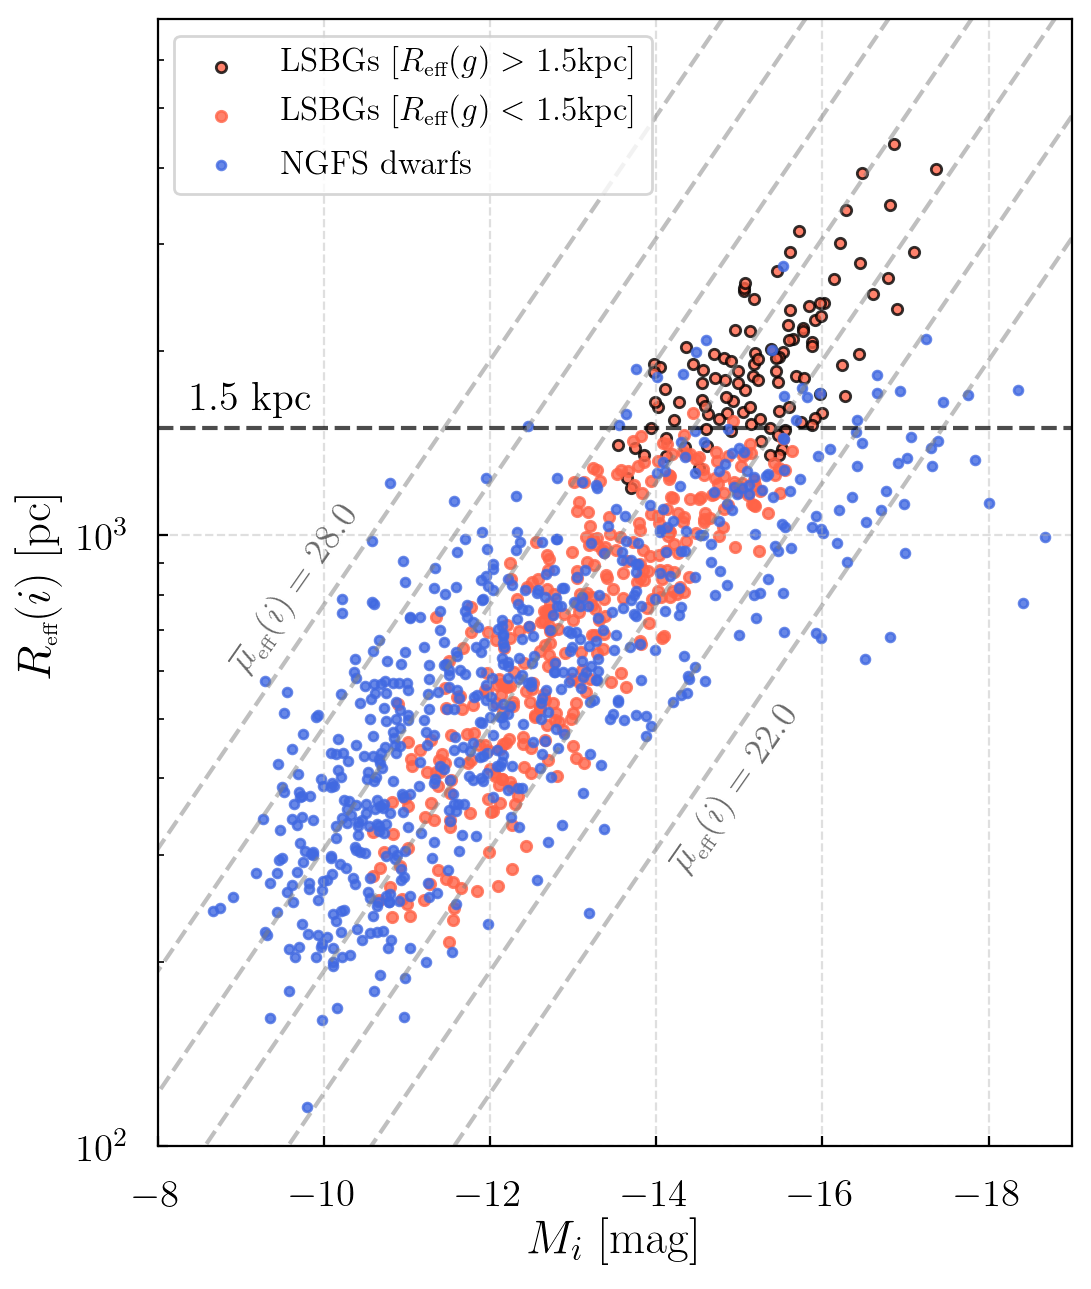

In [49]:
x_s = np.linspace(-8,-19,200)
y_s = 1839.33*np.ones(200)
y_s = 1500.0*np.ones(200)
y_s_2 = 229.91*np.ones(200)

plt.figure(figsize = (5.5,6.5))

plt.scatter(Mag_i_lsb[R_eff_g_lsb>1500],R_eff_i_lsb[R_eff_g_lsb>1500],
            s=14.0, color='tomato', marker='o',edgecolor='k', alpha=0.8,
           label='LSBGs [$R_{\mbox{\scriptsize{eff}}}(g)>$ 1.5kpc]')


#plt.scatter(abs_mag_i,R_eff_i,s=10,color='royalblue', marker='o',
#            alpha=0.8, label='NGFS dwarfs')

plt.scatter(Mag_i_lsb[R_eff_g_lsb<1500],R_eff_i_lsb[R_eff_g_lsb<1500],
            s=14.0, color='tomato', marker='o', alpha=0.8,
            label='LSBGs [$R_{\mbox{\scriptsize{eff}}}(g)<$ 1.5kpc]')



plt.scatter(abs_mag_i,R_eff_i,s=10,color='royalblue', marker='o',
            alpha=0.8, label='NGFS dwarfs')

plt.plot(x_s,y_s, ls='--', color='k',alpha=0.7)
#plt.plot(x_s,y_s_2, ls='--', color='k',alpha=0.7)
plt.plot(M_mag, R_arr_22, ls='--',color='gray', alpha=0.5)
plt.plot(M_mag, R_arr_23, ls='--',color='gray', alpha=0.5)
plt.plot(M_mag, R_arr_24, ls='--',color='gray', alpha=0.5)
plt.plot(M_mag, R_arr_25, ls='--',color='gray', alpha=0.5)
plt.plot(M_mag, R_arr_26, ls='--',color='gray', alpha=0.5)
plt.plot(M_mag, R_arr_27, ls='--',color='gray', alpha=0.5)
plt.plot(M_mag, R_arr_28, ls='--',color='gray', alpha=0.5)


plt.text(-8.85,1.02e3, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(i)=28.0$',
         color='dimgray',fontsize=13, rotation=55)
plt.text(-14.15,480, '${\overline{\mu}}_{\mbox{\scriptsize{eff}}}(i)=22.0$',
         color='dimgray',fontsize=13, rotation=55)
plt.text(-8.4,1.6e3, '1.5 kpc', fontsize = 14.5)

plt.yscale('log')
plt.ylim(1e2,7e3)
plt.xlim(-8,-19)
plt.grid(ls='--',alpha=0.4)
plt.tick_params(axis='both', labelsize=14)

plt.xlabel('$M_i$ [mag]', fontsize=17)
plt.ylabel('$R_{\mbox{\scriptsize{eff}}}(i)$ [pc]', fontsize=17)

plt.legend(frameon=True, loc='upper left', fontsize=12)

plt.tight_layout()
plt.savefig('Size_Lumin_OC.pdf')
plt.show()

In [50]:
alpha = 4.848e-6


mu_mean_g_loc = Mag_g_lsb -5.+ 2.5*np.log10(2.0*np.pi) + 5.0*np.log10(R_eff_g_lsb/alpha)
print(len(mu_mean_g_loc[mu_mean_g_loc>27]))

1


In [51]:
print(np.median(Mag_g_lsb))

-12.902117068483122


### Correlation functions

i) Of the blue galaxies with $20.5 < g < 19.5$.

ii) The red galaxies with $22 < g < 21$.


#### Let's define the two samples first

In [52]:
blue_cut = (mag_g>19.5)&(mag_g<20.5)&(col_g_i<med_g_i)
red_cut = (mag_g>21.0)&(mag_g<22.0)&(col_g_i>med_g_i)
# =================================
red_ra_1 = RA[red_cut]
red_dec_1 = DEC[red_cut]
blue_ra_1 = RA[blue_cut]
blue_dec_1 = DEC[blue_cut]

#### Now let's calculate the correlation functions

Of the red galaxies first

In [54]:
# Create catalog of red galaxies
cat_red_1 = treecorr.Catalog(ra=red_ra_1, dec=red_dec_1, ra_units='deg', dec_units='deg')
dd_red_1 = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dd_red_1.process(cat_red_1)
dr_red_1 = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dr_red_1.process(cat_red_1, rand)
# Calculate 2pt correlation function of the red sample
xi_red_1, varxi_red_1 = dd_red_1.calculateXi(rr, dr_red_1)
r_red_1 = np.exp(dd_red_1.meanlogr)
sig_red_1 = np.sqrt(varxi_red_1)
# Calculate Jackknife errors
# Calculate red galaxies errors
Errors_red_1 = Jackknife(red_ra_1, red_dec_1, rand_ra_pos, rand_dec_pos, 100)

And the blue galaxies now

In [56]:
# Create catalog of blue galaxies
cat_blue_1 = treecorr.Catalog(ra=blue_ra_1, dec=blue_dec_1, ra_units='deg', dec_units='deg')
dd_blue_1 = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dd_blue_1.process(cat_blue_1)
dr_blue_1 = treecorr.NNCorrelation(min_sep=0.01, max_sep=20, bin_size=0.4, sep_units='degrees')
dr_blue_1.process(cat_blue_1, rand)
#Calculate 2pt correlation function of the blue sample
xi_blue_1, varxi_blue_1 = dd_blue_1.calculateXi(rr, dr_blue_1)
r_blue_1 = np.exp(dd_blue_1.meanlogr)
sig_blue_1 = np.sqrt(varxi_blue_1)
# Calculate Jackknife errors
# Calculate blue galaxies errors
Errors_blue_1 = Jackknife(blue_ra_1, blue_dec_1, rand_ra_pos, rand_dec_pos, 100)

Finally, let's make a nice plot!

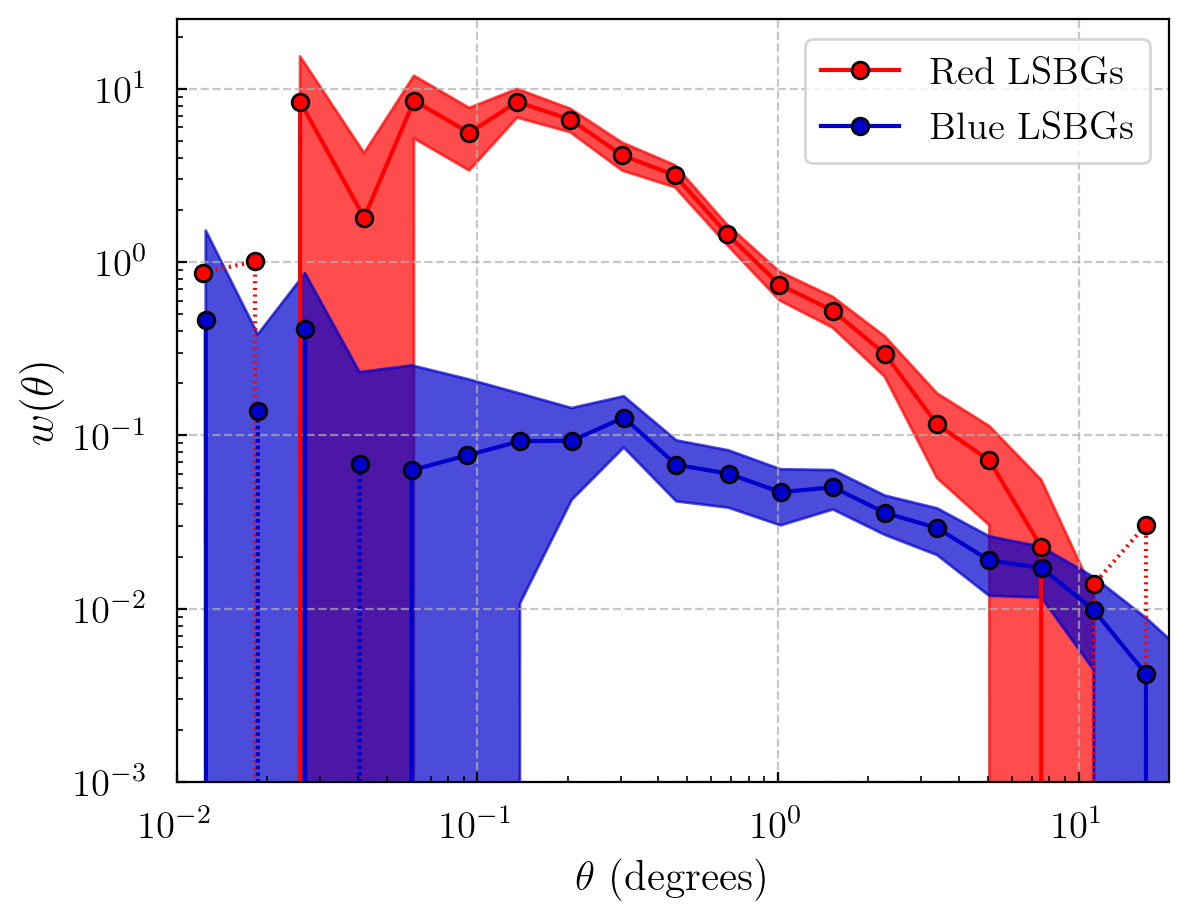

In [59]:
plt.figure(figsize = (6.,4.65))

# red galaxies
plt.plot(r_red_1, xi_red_1, color='r',marker='o', markeredgecolor='k', label='Red LSBGs')
plt.plot(r_red_1, -xi_red_1, color='r',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_red_1, xi_red_1-Errors_red_1, xi_red_1+Errors_red_1, color='r', alpha=0.7)


# blue galaxies
plt.plot(r_blue_1, xi_blue_1, color='mediumblue',marker='o', markeredgecolor='k', label='Blue LSBGs')
plt.plot(r_blue_1, -xi_blue_1, color='mediumblue',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_blue_1, xi_blue_1-Errors_blue_1, xi_blue_1+Errors_blue_1, color='mediumblue', alpha=0.7)


plt.grid(ls='--',alpha=0.7)
plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)', fontsize=15)



plt.ylabel(r'$w(\theta)$', fontsize=16)
plt.legend(frameon=True, loc='upper right', fontsize=14)
plt.xlim([0.01,20]);plt.ylim(1.0e-3)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.savefig('red_vs_blue_1.pdf')
plt.show()

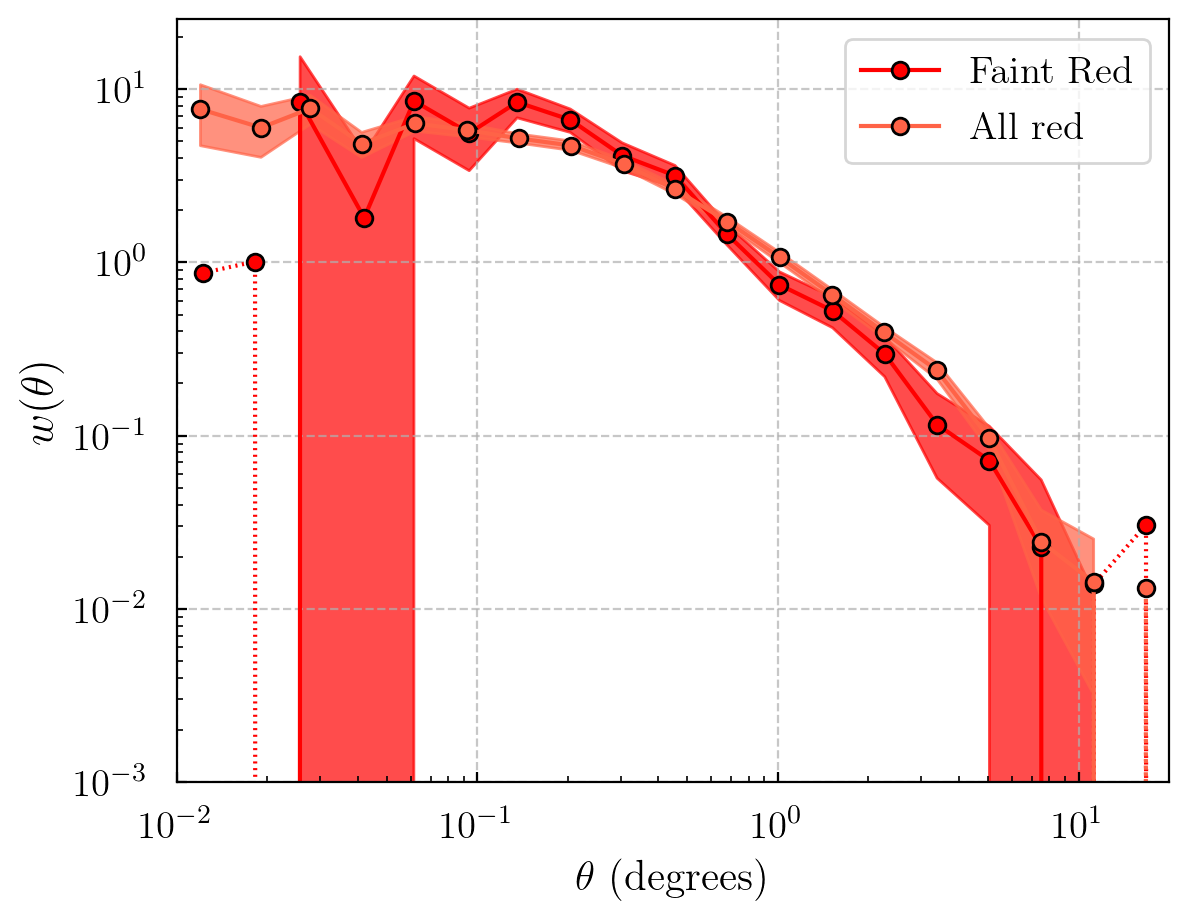

In [60]:
plt.figure(figsize = (6.,4.65))

# red galaxies
plt.plot(r_red_1, xi_red_1, color='r',marker='o', markeredgecolor='k', label='Faint Red')
plt.plot(r_red_1, -xi_red_1, color='r',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_red_1, xi_red_1-Errors_red_1, xi_red_1+Errors_red_1, color='r', alpha=0.7)


# blue galaxies
plt.plot(r_red, xi_red, color='tomato',marker='o', markeredgecolor='k', label='All red')
plt.plot(r_red, -xi_red, color='tomato',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_red, xi_red-Errors_red, xi_red+Errors_red, color='tomato', alpha=0.7)


plt.grid(ls='--',alpha=0.7)
plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)', fontsize=15)



plt.ylabel(r'$w(\theta)$', fontsize=16)
plt.legend(frameon=True, loc='upper right', fontsize=14)
plt.xlim([0.01,20]);plt.ylim(1.0e-3)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.savefig('red_faint_red.pdf')
plt.show()

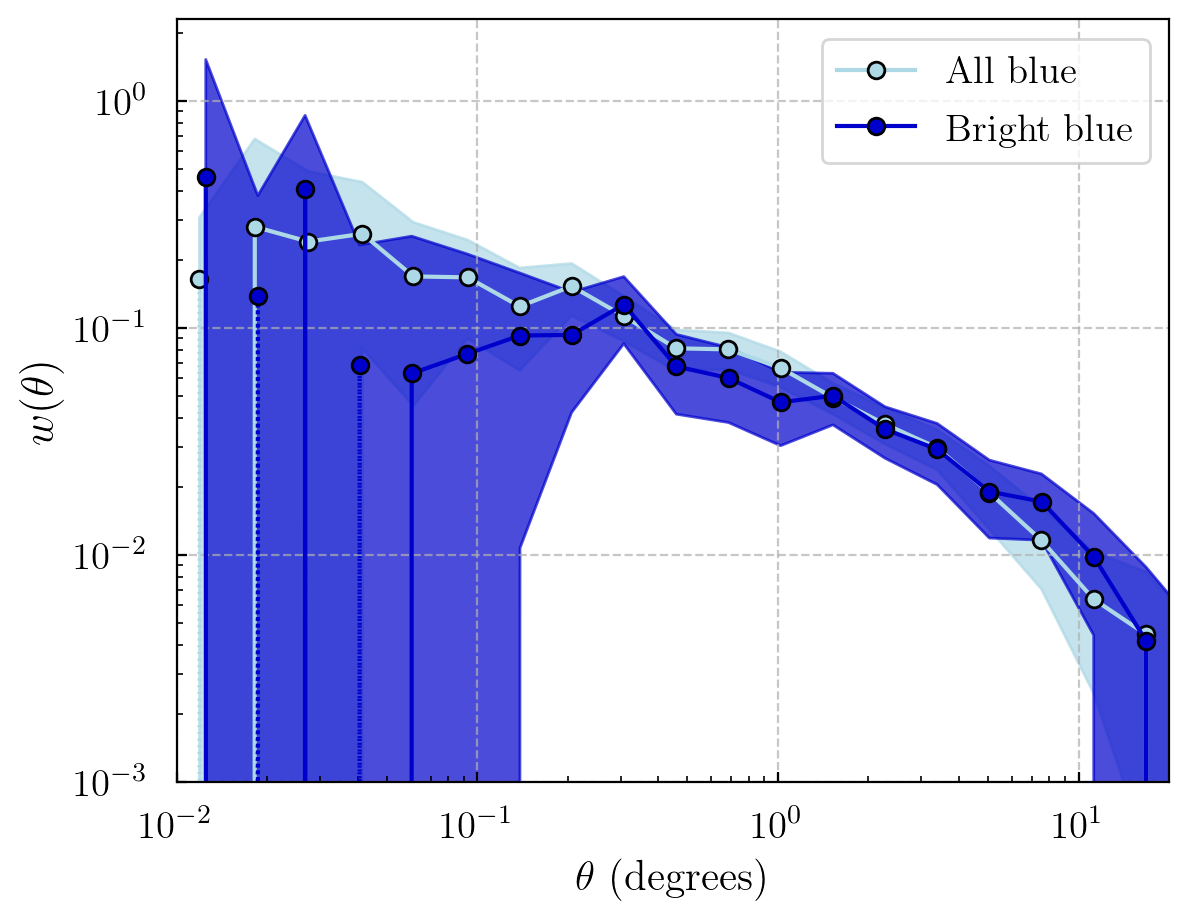

In [61]:
plt.figure(figsize = (6.,4.65))

# red galaxies
plt.plot(r_blue, xi_blue, color='lightblue',marker='o', markeredgecolor='k', label='All blue')
plt.plot(r_blue, -xi_blue, color='lightblue',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_blue, xi_blue-Errors_blue, xi_blue+Errors_blue, color='lightblue', alpha=0.7)


# blue galaxies
plt.plot(r_blue_1, xi_blue_1, color='mediumblue',marker='o', markeredgecolor='k', label='Bright blue')
plt.plot(r_blue_1, -xi_blue_1, color='mediumblue',marker='o', markeredgecolor='k', ls=':')
plt.fill_between(r_blue_1, xi_blue_1-Errors_blue_1, xi_blue_1+Errors_blue_1, color='mediumblue', alpha=0.7)


plt.grid(ls='--',alpha=0.7)
plt.xscale('log')
plt.yscale('log', nonposy='clip')
plt.xlabel(r'$\theta$ (degrees)', fontsize=15)



plt.ylabel(r'$w(\theta)$', fontsize=16)
plt.legend(frameon=True, loc='upper right', fontsize=14)
plt.xlim([0.01,20]);plt.ylim(1.0e-3)
plt.tick_params(axis='both', labelsize=14)
plt.tight_layout()
plt.savefig('blue_bright_blue.pdf')
plt.show()

In [62]:
print(len(mu_mean_g_loc))

463
